In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary

from matplotlib import pyplot as plt

import time as time

# Download CIFAR10 Dataset

In [6]:
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='.', train=False, download=True, transform=transform)

In [7]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [10]:
def plot_examples(dataset):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img, label = dataset[i]
        ax.imshow(img.permute(1,2,0))
        ax.set_title(f"{labels[label]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

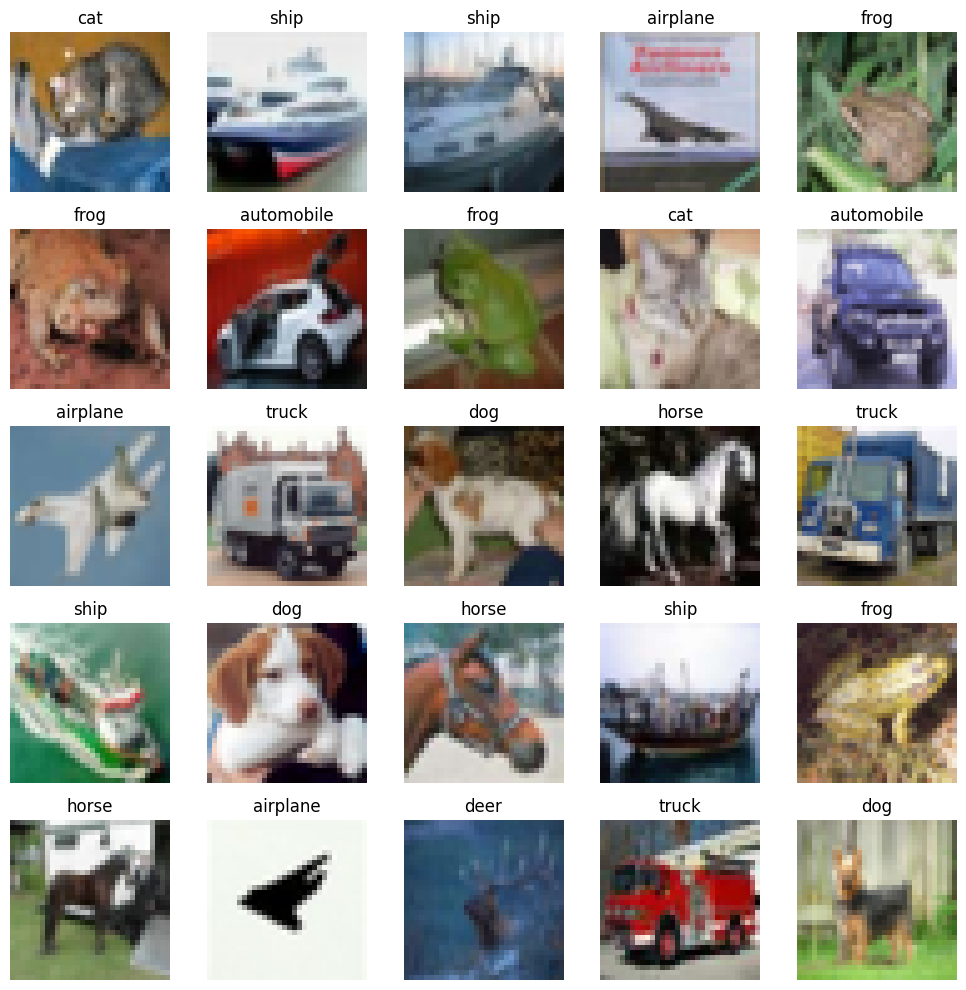

In [11]:
plot_examples(test_dataset)

# Define Basic Models

In [77]:
def initialize_models():
    models = {}

    ## Fully connected variants
    models['fully_connected_dropout'] = nn.Sequential(
        nn.Flatten(),              # Flattens [3, 32, 32] → [3072]
        nn.Linear(3072, 1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 10)         # Output layer (10 classes)
    )
    
    models['fully_connected'] = nn.Sequential(
        nn.Flatten(),              # Flattens [3, 32, 32] → [3072]
        nn.Linear(3072, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Linear(128, 10)         # Output layer (10 classes)
    )

    models['simple_cnn'] = nn.Sequential(

        # input: 3x32x32
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same'), # 16x32x32
        nn.ReLU(),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 'same'), # 32x32x32
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # 32x16x16

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 'same'), # 64x16x16
        nn.ReLU(),
        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 'same'), # 64x16x16
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # 64x8x8

        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 'same'), # 128x8x8
        nn.ReLU(),
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 'same'), # 128x8x8
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # 128x4x4

        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding='same'), # 256x4x4
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1), # 256x1x1

        nn.Flatten(),
        
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

    models['simple_cnn_dropout'] = nn.Sequential(

        # input: 3x32x32
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same'), # 16x32x32
        nn.ReLU(),
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 'same'), # 32x32x32
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # 32x16x16
        nn.Dropout(0.2),

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 'same'), # 64x16x16
        nn.ReLU(),
        nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 'same'), # 64x16x16
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # 64x8x8
        nn.Dropout(0.2),

        nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 'same'), # 128x8x8
        nn.ReLU(),
        nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 'same'), # 128x8x8
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2), # 128x4x4
        nn.Dropout(0.2),

        nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding='same'), # 256x4x4
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1), # 256x1x1

        nn.Flatten(),
        
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

    return models

In [78]:
test_models = initialize_models()
for name, model in test_models.items():
    print(f'SUMMARIZING MODEL: {name}')
    print('\n')
    summary(model, input_size=(3, 32, 32), device='cpu')
    print('\n')

SUMMARIZING MODEL: fully_connected_dropout


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                 [-1, 1024]       3,146,752
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
              ReLU-6                  [-1, 512]               0
           Dropout-7                  [-1, 512]               0
            Linear-8                  [-1, 128]          65,664
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 3,738,506
Trainable params: 3,738,506
Non-trainable params: 0
----------------------------------------------

# Train Basic Models

## Define helper functions, check performance before training

In [12]:
def get_label(model, img):
    model.eval()
    model.cpu()
    output = model(img)
    probs = torch.softmax(output, dim=1)
    label = torch.argmax(probs, dim=1)
    return label.item()

In [13]:
def plot_examples_with_predictions(model, dataset):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        img, label = dataset[i]
        true_label = labels[label]
        pred_label = labels[get_label(model, img.unsqueeze(0))]
        ax.imshow(img.permute(1,2,0))
        ax.set_title(f"{true_label} / {pred_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [14]:
def get_accuracy(model, loader):

    correct = 0
    total = 0
    
    with torch.no_grad():  # No gradients needed for evaluation
        model.eval()
        for images, labels in loader:
            outputs = model(images)             # Get logits
            predicted = torch.argmax(outputs, dim=1)
            # alternatively, might use torch.max() and only use the 2nd return (indices), while ignoring the first (actual max values)
            #_, predicted = torch.max(outputs, dim = 1)  # Get predicted class indices; could also use argmax since only need labels for now

            total += labels.size(0)             # Number of samples in batch
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f'Accuracy on test set: {accuracy * 100:.2f}%')

In [15]:
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
#for model in models:
#    print(f"** Model: {model}")
#    get_accuracy(models[model], test_loader)

## Define the Training Loop and plotting functions

In [16]:
def models_to_device(models):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'device: {device}')
    for _, model in models.items():
        model = model.to(device)

In [17]:
val_size = 5000
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [18]:
def train(model, train_loader, val_loader, num_epochs, lr=1e-3, reduce_lr = None):
    training_loss = []
    validation_loss = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    criterion = nn.CrossEntropyLoss()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    start = time.time()
    
    for epoch in range(num_epochs):
        ### training pass

        # check if need to reduce the lr
        if reduce_lr is not None:
            if (epoch+1) in reduce_lr:
                for pg in optimizer.param_groups:
                    pg['lr'] *= 0.1
                print(f"Epoch {epoch+1}: LR reduced to {optimizer.param_groups[0]['lr']}")
        
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        ### check performance on the validation set
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
    
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                predicted = torch.argmax(outputs, dim=1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
    
        val_loss /= len(val_loader)
        val_acc = correct / total
        
        train_loss /= len(train_loader)
        training_loss.append(train_loss)
        validation_loss.append(val_loss)
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}, Loss: {train_loss:.4f} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc * 100:.2f}%")
    
    print(f'Training complete in {time.time()-start:.4f}s.')
    return training_loss, validation_loss

In [19]:
def plot_losses(train_loss, val_loss, models):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, model in enumerate(models):
        t_loss = train_loss[model]
        v_loss = val_loss[model]
        n = len(t_loss)
        assert len(t_loss) == len(v_loss)
        plt.plot(range(n), t_loss, label=f'Train {model}', color=colors[i])
        plt.plot(range(n), v_loss, '--', label=f'Val {model}', color=colors[i])
    plt.legend()
    plt.ylabel("Loss")

In [134]:
def print_accuracies(models, test_loader = test_loader):
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    for model_name, model in models.items():
        print(f"** Model: {model_name}")
        model.to('cpu')
        model.eval()
        get_accuracy(model, test_loader)

## Train with various settings and evaluate

### LR = $10^{-4}$

In [65]:
models_lr_0_0001 = initialize_models()
models_to_device(models_lr_0_0001)
train_loss = {}
val_loss = {}
for model_name, model in models_lr_0_0001.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=50, lr=1e-4)
    print('*'*20, '\n')

device: cuda
=== Training fully_connected_dropout
Epoch 10, Loss: 1.4724 Validation Loss: 1.4478, Validation Accuracy: 48.16%
Epoch 20, Loss: 1.2924 Validation Loss: 1.3229, Validation Accuracy: 52.38%
Epoch 30, Loss: 1.1518 Validation Loss: 1.2820, Validation Accuracy: 54.64%
Epoch 40, Loss: 1.0328 Validation Loss: 1.2858, Validation Accuracy: 54.64%
Epoch 50, Loss: 0.9279 Validation Loss: 1.2818, Validation Accuracy: 56.78%
Training complete in 176.4350s.
******************** 

=== Training fully_connected
Epoch 10, Loss: 1.3545 Validation Loss: 1.4226, Validation Accuracy: 49.52%
Epoch 20, Loss: 1.1121 Validation Loss: 1.3246, Validation Accuracy: 53.76%
Epoch 30, Loss: 0.8941 Validation Loss: 1.3411, Validation Accuracy: 55.24%
Epoch 40, Loss: 0.6849 Validation Loss: 1.4302, Validation Accuracy: 55.40%
Epoch 50, Loss: 0.4835 Validation Loss: 1.6901, Validation Accuracy: 54.70%
Training complete in 169.0019s.
******************** 

=== Training simple_cnn
Epoch 10, Loss: 1.3285 Vali

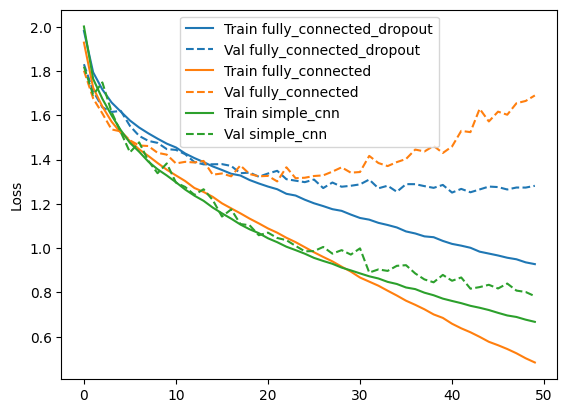

In [66]:
plot_losses(train_loss, val_loss, models_lr_0_0001)

In [67]:
print_accuracies(models_lr_0_0001)

** Model: fully_connected_dropout
Accuracy on test set: 56.21%
** Model: fully_connected
Accuracy on test set: 54.46%
** Model: simple_cnn
Accuracy on test set: 72.84%


Summary: both FC models overfit but Dropout is somewhat better. Both have pretty bad accuracy. However even the simplest CNN performs much better.

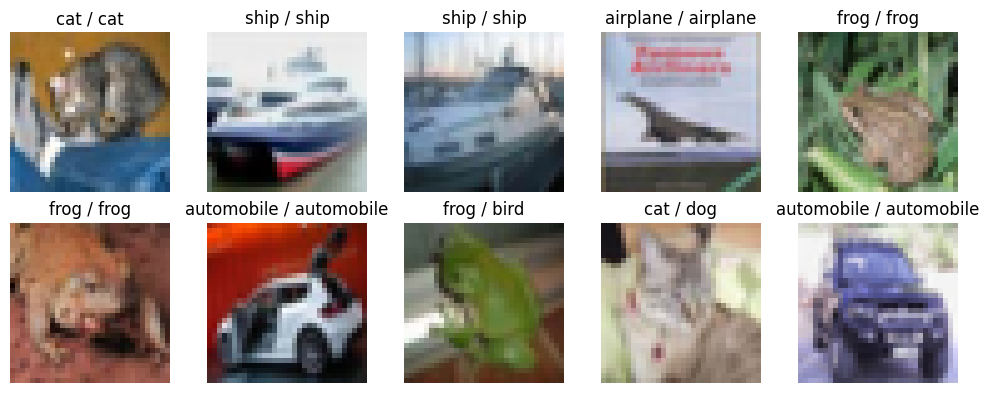

In [68]:
plot_examples_with_predictions(models_lr_0_0001['simple_cnn'], test_dataset)

### LR = $10^{-3}$

Let's try with a larger learning rate

In [79]:
models_lr_0_001 = initialize_models()
train_loss = {}
val_loss = {}
for model_name, model in models_lr_0_001.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=50, lr=1e-3)
    print('*'*20)

=== Training fully_connected_dropout
Epoch 10, Loss: 1.5869 Validation Loss: 1.5393, Validation Accuracy: 44.60%
Epoch 20, Loss: 1.4930 Validation Loss: 1.4646, Validation Accuracy: 46.70%
Epoch 30, Loss: 1.4384 Validation Loss: 1.4332, Validation Accuracy: 47.94%
Epoch 40, Loss: 1.3909 Validation Loss: 1.4193, Validation Accuracy: 48.70%
Epoch 50, Loss: 1.3596 Validation Loss: 1.4126, Validation Accuracy: 49.48%
Training complete in 174.3019s.
********************
=== Training fully_connected
Epoch 10, Loss: 1.3268 Validation Loss: 1.4173, Validation Accuracy: 49.28%
Epoch 20, Loss: 1.1037 Validation Loss: 1.4296, Validation Accuracy: 50.92%
Epoch 30, Loss: 0.9095 Validation Loss: 1.5975, Validation Accuracy: 50.22%
Epoch 40, Loss: 0.7545 Validation Loss: 1.7820, Validation Accuracy: 50.30%
Epoch 50, Loss: 0.6414 Validation Loss: 2.1247, Validation Accuracy: 49.76%
Training complete in 173.4852s.
********************
=== Training simple_cnn
Epoch 10, Loss: 0.8411 Validation Loss: 0.98

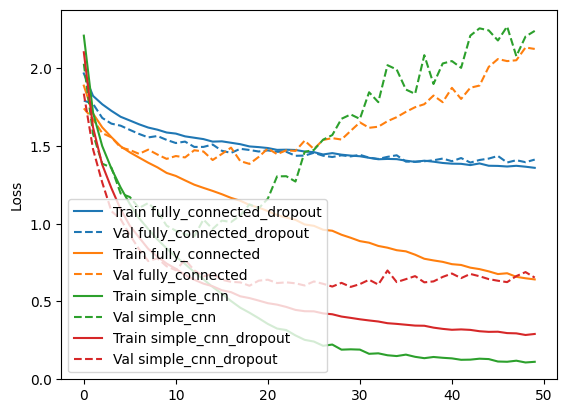

In [80]:
plot_losses(train_loss, val_loss, models_lr_0_001)

In [81]:
print_accuracies(models_lr_0_001)

** Model: fully_connected_dropout
Accuracy on test set: 49.36%
** Model: fully_connected
Accuracy on test set: 49.06%
** Model: simple_cnn
Accuracy on test set: 67.18%
** Model: simple_cnn_dropout
Accuracy on test set: 80.28%


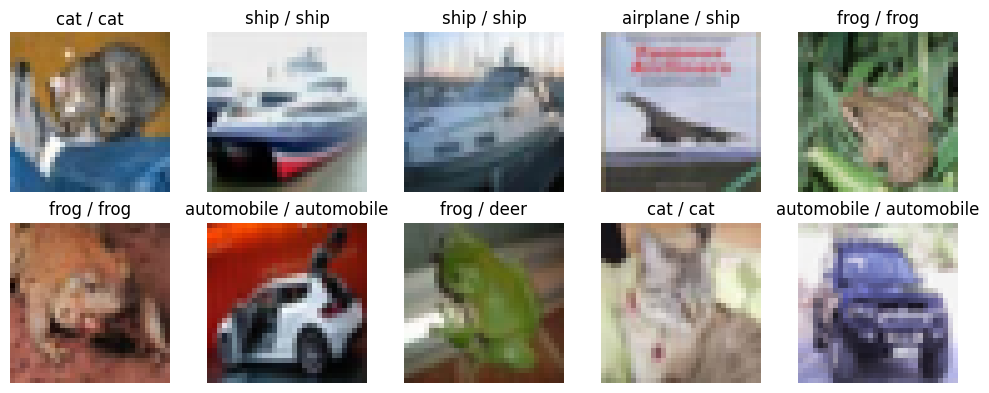

In [82]:
plot_examples_with_predictions(models_lr_0_001['simple_cnn_dropout'], test_dataset)

# Dropout Study

### Model definition

In [16]:
class BasicConvBlock(nn.Module):
    def __init__(self, channels, dropout=0.2, dropout_2d = False): # by setting dropout_2d = False we are compatible to prev code
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 'same')
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels =  channels, out_channels =  2 * channels, kernel_size = 3, padding = 'same')
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(p=dropout) if dropout_2d else nn.Dropout(p=dropout)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)

        return out

class SimpleCNN(nn.Module):

    def __init__(self, dropout = 0.0, dropout_fc=0.5, dropout_2d = False):
        super().__init__()

        self.initial_conv =  nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same')
        self.relu = nn.ReLU(inplace=True)
        
        self.convblock1 = BasicConvBlock(16, dropout=dropout, dropout_2d = dropout_2d)
        self.convblock2 = BasicConvBlock(32, dropout=dropout, dropout_2d = dropout_2d)
        self.convblock3 = BasicConvBlock(64, dropout=dropout, dropout_2d = dropout_2d)
        
        self.final_conv =  nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding='same')

        self.adaptivepool = nn.AdaptiveAvgPool2d(1) # 256x1x1
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(dropout_fc)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # x: 3x32x32
        out = self.initial_conv(x) # 16x32x32
        out = self.relu(out)

        out = self.convblock1(out) # 32x16x16
        out = self.convblock2(out) # 64x8x8
        out = self.convblock3(out) # 128x4x4

        out = self.final_conv(out) # 256x4x4
        out = self.relu(out)

        out = self.adaptivepool(out)  # 256x1x1
        out = self.flatten(out) # 256
        out = self.fc1(out)  # 256
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)  # 10

        return out

In [147]:
def initialize_advanced_models():
    models = {}

    models['simple_cnn_0.0'] = SimpleCNN(dropout = 0, dropout_fc = 0)
    models['simple_cnn_0.1'] = SimpleCNN(dropout = 0.1, dropout_fc = 0)
    models['simple_cnn_0.2'] = SimpleCNN(dropout = 0.2, dropout_fc = 0)
    models['simple_cnn_0.3'] = SimpleCNN(dropout = 0.3, dropout_fc = 0)
    models['simple_cnn_0.5'] = SimpleCNN(dropout = 0.5, dropout_fc = 0)

    return models

### LR=$10^{-3}$

In [136]:
models_lr_0_001 = initialize_advanced_models()
train_loss = {}
val_loss = {}
for model_name, model in models_lr_0_001.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=50, lr=1e-3)
    print('*'*20)

=== Training simple_cnn_0.0
Epoch 10, Loss: 0.6545 Validation Loss: 0.7934, Validation Accuracy: 73.16%
Epoch 20, Loss: 0.2275 Validation Loss: 0.9044, Validation Accuracy: 75.66%
Epoch 30, Loss: 0.1053 Validation Loss: 1.5799, Validation Accuracy: 73.70%
Epoch 40, Loss: 0.1010 Validation Loss: 1.5088, Validation Accuracy: 74.50%
Epoch 50, Loss: 0.0698 Validation Loss: 1.7019, Validation Accuracy: 73.68%
Training complete in 216.9111s.
********************
=== Training simple_cnn_0.1
Epoch 10, Loss: 0.7725 Validation Loss: 0.8224, Validation Accuracy: 71.04%
Epoch 20, Loss: 0.4782 Validation Loss: 0.7371, Validation Accuracy: 75.28%
Epoch 30, Loss: 0.3278 Validation Loss: 0.8528, Validation Accuracy: 75.58%
Epoch 40, Loss: 0.2475 Validation Loss: 0.9656, Validation Accuracy: 75.28%
Epoch 50, Loss: 0.2045 Validation Loss: 1.1182, Validation Accuracy: 74.48%
Training complete in 229.5866s.
********************
=== Training simple_cnn_0.2
Epoch 10, Loss: 0.8243 Validation Loss: 0.8513, Va

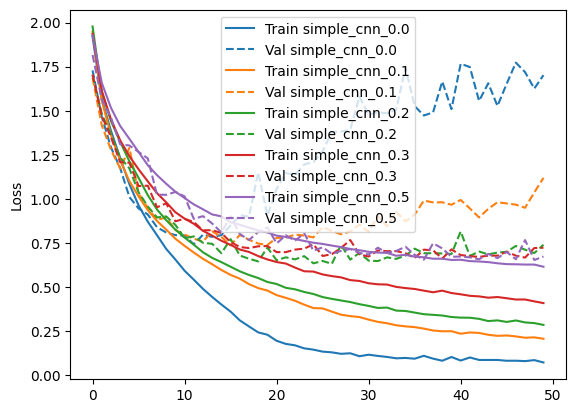

In [137]:
plot_losses(train_loss, val_loss, models_lr_0_001)

In [138]:
print_accuracies(models_lr_0_001)

** Model: simple_cnn_0.0
Accuracy on test set: 72.79%
** Model: simple_cnn_0.1
Accuracy on test set: 73.99%
** Model: simple_cnn_0.2
Accuracy on test set: 78.48%
** Model: simple_cnn_0.3
Accuracy on test set: 78.03%
** Model: simple_cnn_0.5
Accuracy on test set: 77.31%


### LR=$10^{-4}$

In [143]:
models = initialize_advanced_models()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=50, lr=1e-4)
    print('*'*20)

=== Training simple_cnn_0.0
Learning rate: 0.0001
Epoch 10, Loss: 1.4524 Validation Loss: 1.4354, Validation Accuracy: 47.64%
Epoch 20, Loss: 1.2243 Validation Loss: 1.2288, Validation Accuracy: 55.62%
Epoch 30, Loss: 1.0458 Validation Loss: 1.1356, Validation Accuracy: 59.08%
Epoch 40, Loss: 0.8789 Validation Loss: 0.9351, Validation Accuracy: 66.86%
Epoch 50, Loss: 0.7306 Validation Loss: 0.8673, Validation Accuracy: 69.30%
Training complete in 220.4376s.
********************
=== Training simple_cnn_0.1
Learning rate: 0.0001
Epoch 10, Loss: 1.4561 Validation Loss: 1.4277, Validation Accuracy: 47.66%
Epoch 20, Loss: 1.2614 Validation Loss: 1.2467, Validation Accuracy: 55.64%
Epoch 30, Loss: 1.0938 Validation Loss: 1.1129, Validation Accuracy: 59.76%
Epoch 40, Loss: 0.9516 Validation Loss: 0.9960, Validation Accuracy: 64.62%
Epoch 50, Loss: 0.8266 Validation Loss: 0.8744, Validation Accuracy: 68.68%
Training complete in 213.3624s.
********************
=== Training simple_cnn_0.2
Learni

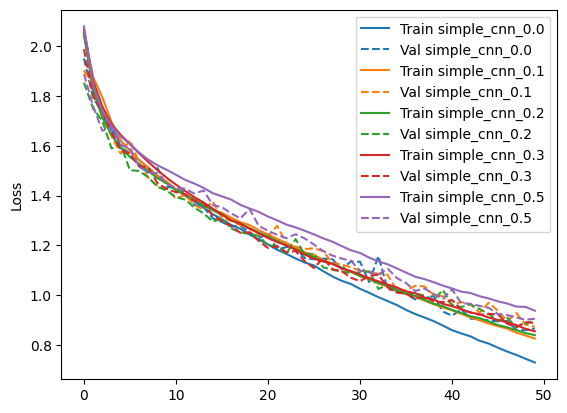

In [144]:
plot_losses(train_loss, val_loss, models)

In [145]:
print_accuracies(models)

** Model: simple_cnn_0.0
Accuracy on test set: 69.51%
** Model: simple_cnn_0.1
Accuracy on test set: 69.25%
** Model: simple_cnn_0.2
Accuracy on test set: 68.07%
** Model: simple_cnn_0.3
Accuracy on test set: 69.18%
** Model: simple_cnn_0.5
Accuracy on test set: 67.90%


### Reduce LR from $10^{-3}$ to $10^{-4}$ after 50 epochs. Also include Dropout after first FC layer

Seems that dropout after every conv layer block is not what we want. Try also after the fully connected layer.

In [154]:
def initialize_advanced_models_v2():
    models = {}

    models['simple_cnn_0.3'] = SimpleCNN(dropout=0.3, dropout_fc = 0)
    models['simple_cnn_0.5'] = SimpleCNN(dropout=0.5, dropout_fc = 0)
    models['simple_cnn_0.0_0.5'] = SimpleCNN(dropout=0.0, dropout_fc = 0.5)
    models['simple_cnn_0.5_0.5'] = SimpleCNN(dropout=0.5, dropout_fc = 0.5)

    return models

In [155]:
models = initialize_advanced_models_v2()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=100, lr=1e-3, reduce_lr = [50])
    print('*'*20)

=== Training simple_cnn_0.3
Learning rate: 0.001
Epoch 10, Loss: 0.8170 Validation Loss: 0.8180, Validation Accuracy: 72.02%
Epoch 20, Loss: 0.5642 Validation Loss: 0.6545, Validation Accuracy: 76.86%
Epoch 30, Loss: 0.4492 Validation Loss: 0.6788, Validation Accuracy: 77.26%
Epoch 40, Loss: 0.3880 Validation Loss: 0.7093, Validation Accuracy: 77.52%
Epoch 50: LR reduced to 0.0001
Epoch 50, Loss: 0.2607 Validation Loss: 0.6757, Validation Accuracy: 80.28%
Epoch 60, Loss: 0.2017 Validation Loss: 0.7361, Validation Accuracy: 80.60%
Epoch 70, Loss: 0.1837 Validation Loss: 0.7232, Validation Accuracy: 80.70%
Epoch 80, Loss: 0.1688 Validation Loss: 0.7547, Validation Accuracy: 80.38%
Epoch 90, Loss: 0.1535 Validation Loss: 0.7683, Validation Accuracy: 80.72%
Epoch 100, Loss: 0.1494 Validation Loss: 0.7802, Validation Accuracy: 80.90%
Training complete in 446.2282s.
********************
=== Training simple_cnn_0.5
Learning rate: 0.001
Epoch 10, Loss: 1.0848 Validation Loss: 1.0679, Validatio

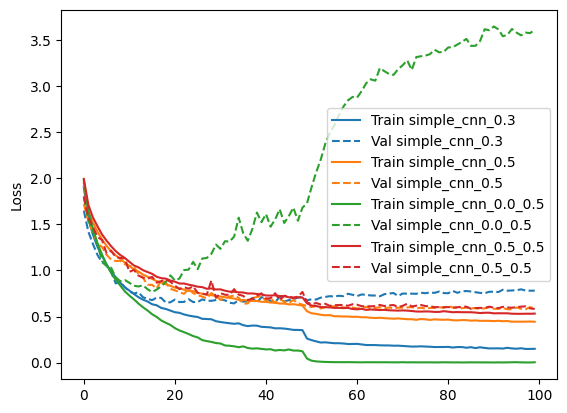

In [156]:
plot_losses(train_loss, val_loss, models)

In [158]:
print_accuracies(models)

** Model: simple_cnn_0.3
Accuracy on test set: 80.88%
** Model: simple_cnn_0.5
Accuracy on test set: 80.43%
** Model: simple_cnn_0.0_0.5
Accuracy on test set: 75.12%
** Model: simple_cnn_0.5_0.5
Accuracy on test set: 80.56%


### More studies on dropout

In [160]:
def initialize_advanced_models_v3():
    models = {}

    models['simple_cnn_0.51d_0.5'] = SimpleCNN(dropout=0.5, dropout_fc = 0.5, dropout_2d = False)
    models['simple_cnn_0.52d_0.5'] = SimpleCNN(dropout=0.5, dropout_fc = 0.5, dropout_2d = True)

    return models

models = initialize_advanced_models_v3()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=100, lr=1e-3, reduce_lr = [50])
    print('*'*20)

=== Training simple_cnn_0.51d_0.5
Learning rate: 0.001
Epoch 10, Loss: 1.0946 Validation Loss: 0.9813, Validation Accuracy: 64.28%
Epoch 20, Loss: 0.8854 Validation Loss: 0.7782, Validation Accuracy: 72.42%
Epoch 30, Loss: 0.7932 Validation Loss: 0.7894, Validation Accuracy: 73.00%
Epoch 40, Loss: 0.7414 Validation Loss: 0.6734, Validation Accuracy: 76.92%
Epoch 50: LR reduced to 0.0001
Epoch 50, Loss: 0.6353 Validation Loss: 0.6542, Validation Accuracy: 77.80%
Epoch 60, Loss: 0.5765 Validation Loss: 0.6212, Validation Accuracy: 78.88%
Epoch 70, Loss: 0.5556 Validation Loss: 0.6164, Validation Accuracy: 78.94%
Epoch 80, Loss: 0.5447 Validation Loss: 0.6214, Validation Accuracy: 78.96%
Epoch 90, Loss: 0.5356 Validation Loss: 0.6011, Validation Accuracy: 79.28%
Epoch 100, Loss: 0.5243 Validation Loss: 0.5998, Validation Accuracy: 79.82%
Training complete in 447.4137s.
********************
=== Training simple_cnn_0.52d_0.5
Learning rate: 0.001
Epoch 10, Loss: 1.4137 Validation Loss: 1.293

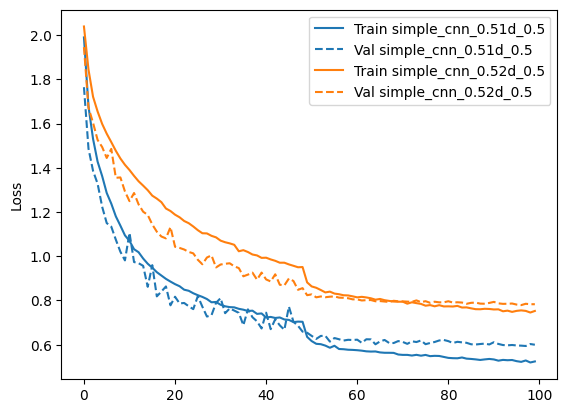

In [161]:
plot_losses(train_loss, val_loss, models)

In [162]:
print_accuracies(models)

** Model: simple_cnn_0.51d_0.5
Accuracy on test set: 79.67%
** Model: simple_cnn_0.52d_0.5
Accuracy on test set: 72.15%


### Same but reduce LR twice

In [163]:
models = initialize_advanced_models_v3()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=100, lr=1e-3, reduce_lr = [30, 60])
    print('*'*20)

=== Training simple_cnn_0.51d_0.5
Learning rate: 0.001
Epoch 10, Loss: 1.1337 Validation Loss: 0.9894, Validation Accuracy: 64.74%
Epoch 20, Loss: 0.9134 Validation Loss: 0.8611, Validation Accuracy: 70.08%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.7499 Validation Loss: 0.6940, Validation Accuracy: 75.48%
Epoch 40, Loss: 0.6931 Validation Loss: 0.6758, Validation Accuracy: 76.38%
Epoch 50, Loss: 0.6649 Validation Loss: 0.6577, Validation Accuracy: 76.92%
Epoch 60: LR reduced to 1e-05
Epoch 60, Loss: 0.6354 Validation Loss: 0.6516, Validation Accuracy: 77.30%
Epoch 70, Loss: 0.6339 Validation Loss: 0.6501, Validation Accuracy: 77.60%
Epoch 80, Loss: 0.6392 Validation Loss: 0.6467, Validation Accuracy: 77.54%
Epoch 90, Loss: 0.6374 Validation Loss: 0.6447, Validation Accuracy: 77.74%
Epoch 100, Loss: 0.6282 Validation Loss: 0.6431, Validation Accuracy: 77.86%
Training complete in 446.9393s.
********************
=== Training simple_cnn_0.52d_0.5
Learning rate: 0.001
Epoch 10, Loss:

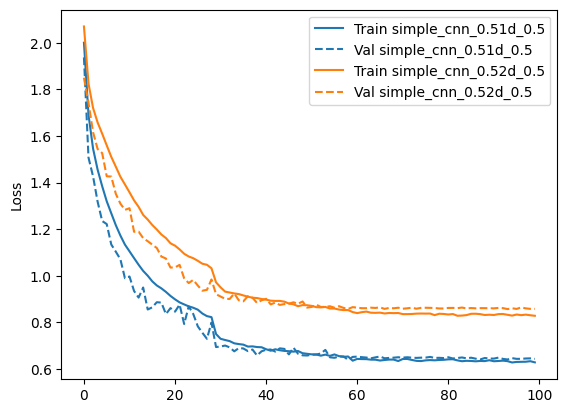

In [164]:
plot_losses(train_loss, val_loss, models)

In [165]:
print_accuracies(models)

** Model: simple_cnn_0.51d_0.5
Accuracy on test set: 77.66%
** Model: simple_cnn_0.52d_0.5
Accuracy on test set: 69.67%


### Change constructors for better dropout control; add dropout after final conv

In [18]:
class BasicConvBlockv2(nn.Module):
    def __init__(self, channels, dropout=0.0, dropout_2d = False): # by setting dropout_2d = False we are compatible to prev code
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 'same')
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels =  channels, out_channels =  2 * channels, kernel_size = 3, padding = 'same')
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(p=dropout) if dropout_2d else nn.Dropout(p=dropout)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

class SimpleCNNv2(nn.Module):
    def __init__(self, dropout_conv_block = 0.2, dropout_final_conv = 0.2, dropout_2d = True, dropout_fc=0.5):
        super().__init__()

        self.initial_conv =  nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same')
        self.relu = nn.ReLU(inplace=True)
        
        self.convblock1 = BasicConvBlockv2(16, dropout=dropout_conv_block, dropout_2d = dropout_2d)
        self.convblock2 = BasicConvBlockv2(32, dropout=dropout_conv_block, dropout_2d = dropout_2d)
        self.convblock3 = BasicConvBlockv2(64, dropout=dropout_conv_block, dropout_2d = dropout_2d)
        
        self.final_conv =  nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding='same')
        self.dropout_final_conv = nn.Dropout2d(p=dropout_final_conv) if dropout_2d else nn.Dropout(p=dropout_final_conv) 

        self.adaptivepool = nn.AdaptiveAvgPool2d(1) # 256x1x1
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(dropout_fc)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # x: 3x32x32
        out = self.initial_conv(x) # 16x32x32
        out = self.relu(out)

        out = self.convblock1(out) # 32x16x16
        out = self.convblock2(out) # 64x8x8
        out = self.convblock3(out) # 128x4x4

        out = self.final_conv(out) # 256x4x4
        out = self.relu(out)
        out = self.dropout_final_conv(out)

        out = self.adaptivepool(out)  # 256x1x1
        out = self.flatten(out) # 256
        out = self.fc1(out)  # 256
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)  # 10

        return out

In [169]:
def initialize_advanced_models_v4():
    models = {}

    models['simple_cnn_0.2_0.2_1d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.2, dropout_final_conv = 0.2, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_0.2_0.2_2d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.2, dropout_final_conv = 0.2, dropout_2d = True, dropout_fc=0.0)
    models['simple_cnn_0.2_0.2_2d_0.5'] = SimpleCNNv2(dropout_conv_block = 0.2, dropout_final_conv = 0.2, dropout_2d = True, dropout_fc=0.5)
    models['simple_cnn_0.5_0.5_2d_0.5'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.5, dropout_2d = True, dropout_fc=0.5)
    models['simple_cnn_0.5_0.5_1d_0.5'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.5, dropout_2d = False, dropout_fc=0.5)

    return models

In [171]:
models = initialize_advanced_models_v4()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=100, lr=1e-3, reduce_lr = [30])
    print('*'*20)

=== Training simple_cnn_0.2_0.2_1d_0.0
Learning rate: 0.001
Epoch 10, Loss: 0.8986 Validation Loss: 0.8755, Validation Accuracy: 69.40%
Epoch 20, Loss: 0.6427 Validation Loss: 0.6853, Validation Accuracy: 76.32%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.4442 Validation Loss: 0.6279, Validation Accuracy: 79.08%
Epoch 40, Loss: 0.3792 Validation Loss: 0.6130, Validation Accuracy: 80.24%
Epoch 50, Loss: 0.3519 Validation Loss: 0.6133, Validation Accuracy: 80.64%
Epoch 60, Loss: 0.3339 Validation Loss: 0.6105, Validation Accuracy: 80.76%
Epoch 70, Loss: 0.3174 Validation Loss: 0.6208, Validation Accuracy: 80.76%
Epoch 80, Loss: 0.3014 Validation Loss: 0.6209, Validation Accuracy: 80.98%
Epoch 90, Loss: 0.2858 Validation Loss: 0.6427, Validation Accuracy: 80.64%
Epoch 100, Loss: 0.2751 Validation Loss: 0.6363, Validation Accuracy: 81.28%
Training complete in 436.4125s.
********************
=== Training simple_cnn_0.2_0.2_2d_0.0
Learning rate: 0.001
Epoch 10, Loss: 1.0232 Validation L

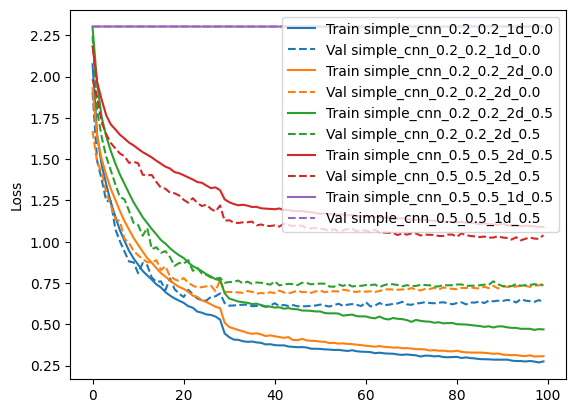

In [172]:
plot_losses(train_loss, val_loss, models)

In [173]:
print_accuracies(models)

** Model: simple_cnn_0.2_0.2_1d_0.0
Accuracy on test set: 80.66%
** Model: simple_cnn_0.2_0.2_2d_0.0
Accuracy on test set: 76.68%
** Model: simple_cnn_0.2_0.2_2d_0.5
Accuracy on test set: 75.74%
** Model: simple_cnn_0.5_0.5_2d_0.5
Accuracy on test set: 62.85%
** Model: simple_cnn_0.5_0.5_1d_0.5
Accuracy on test set: 10.00%


In [174]:
def initialize_advanced_models_v5():
    models = {}

    models['simple_cnn_0.5_0.0_1d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.0, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_0.5_0.0_2d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.0, dropout_2d = True, dropout_fc=0.0)
    models['simple_cnn_0.5_0.0_1d_0.5'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.0, dropout_2d = False, dropout_fc=0.5)
    models['simple_cnn_0.5_0.0_2d_0.5'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.0, dropout_2d = True, dropout_fc=0.5)
    models['simple_cnn_0.5_0.1_1d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_0.5_0.1_1d_0.5'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.5)
    models['simple_cnn_0.1_0.1_2d_0.5'] = SimpleCNNv2(dropout_conv_block = 0.1, dropout_final_conv = 0.1, dropout_2d = True, dropout_fc=0.5)
    models['simple_cnn_0.1_0.2_2d_0.5'] = SimpleCNNv2(dropout_conv_block = 0.1, dropout_final_conv = 0.2, dropout_2d = True, dropout_fc=0.5)

    return models

In [175]:
models = initialize_advanced_models_v5()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=100, lr=1e-3, reduce_lr = [30])
    print('*'*20)

=== Training simple_cnn_0.5_0.0_1d_0.0
Learning rate: 0.001
Epoch 10, Loss: 1.0959 Validation Loss: 1.1187, Validation Accuracy: 59.52%
Epoch 20, Loss: 0.8873 Validation Loss: 0.8777, Validation Accuracy: 68.76%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.7102 Validation Loss: 0.7135, Validation Accuracy: 74.26%
Epoch 40, Loss: 0.6595 Validation Loss: 0.6758, Validation Accuracy: 76.04%
Epoch 50, Loss: 0.6389 Validation Loss: 0.6895, Validation Accuracy: 75.94%
Epoch 60, Loss: 0.6203 Validation Loss: 0.6796, Validation Accuracy: 75.66%
Epoch 70, Loss: 0.6055 Validation Loss: 0.6737, Validation Accuracy: 76.32%
Epoch 80, Loss: 0.5898 Validation Loss: 0.6704, Validation Accuracy: 76.12%
Epoch 90, Loss: 0.5767 Validation Loss: 0.6377, Validation Accuracy: 77.02%
Epoch 100, Loss: 0.5649 Validation Loss: 0.6458, Validation Accuracy: 76.92%
Training complete in 443.9680s.
********************
=== Training simple_cnn_0.5_0.0_2d_0.0
Learning rate: 0.001
Epoch 10, Loss: 1.4031 Validation L

In [182]:
ex1 = {k: models[k] for k in ('simple_cnn_0.5_0.0_1d_0.0', 'simple_cnn_0.5_0.0_2d_0.0', 'simple_cnn_0.5_0.0_1d_0.5', 'simple_cnn_0.5_0.0_2d_0.5')}
ex2 = {k: models[k] for k in ('simple_cnn_0.5_0.0_1d_0.0', 'simple_cnn_0.5_0.1_1d_0.0', 'simple_cnn_0.5_0.1_1d_0.5')}
ex3 = {k: models[k] for k in ('simple_cnn_0.1_0.1_2d_0.5', 'simple_cnn_0.1_0.2_2d_0.5')}

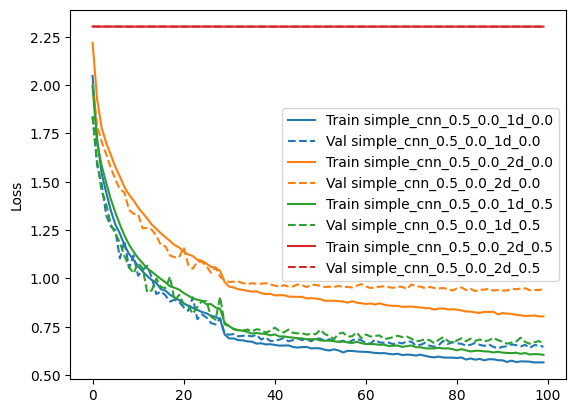

In [183]:
plot_losses(train_loss, val_loss, ex1)

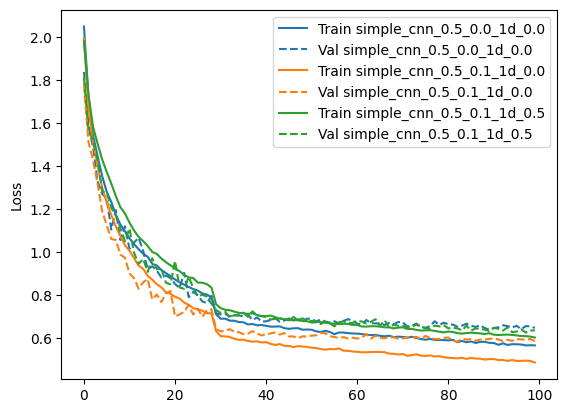

In [184]:
plot_losses(train_loss, val_loss, ex2)

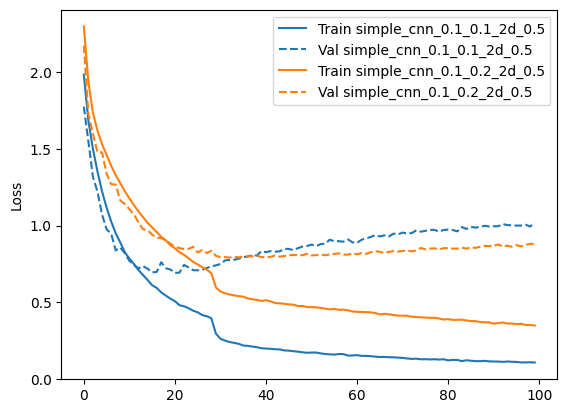

In [185]:
plot_losses(train_loss, val_loss, ex3)

In [177]:
print_accuracies(models)

** Model: simple_cnn_0.5_0.0_1d_0.0
Accuracy on test set: 77.83%
** Model: simple_cnn_0.5_0.0_2d_0.0
Accuracy on test set: 66.04%
** Model: simple_cnn_0.5_0.0_1d_0.5
Accuracy on test set: 76.75%
** Model: simple_cnn_0.5_0.0_2d_0.5
Accuracy on test set: 10.00%
** Model: simple_cnn_0.5_0.1_1d_0.0
Accuracy on test set: 79.27%
** Model: simple_cnn_0.5_0.1_1d_0.5
Accuracy on test set: 77.40%
** Model: simple_cnn_0.1_0.1_2d_0.5
Accuracy on test set: 78.14%
** Model: simple_cnn_0.1_0.2_2d_0.5
Accuracy on test set: 73.41%


### Run the best models again, and introduce v3 where the final conv dropout is AFTER the avg pool!

In [17]:
class SimpleCNNv3(nn.Module):
    def __init__(self, dropout_conv_block = 0.2, dropout_final_conv = 0.2, dropout_2d = True, dropout_fc=0.5):
        super().__init__()

        self.initial_conv =  nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same')
        self.relu = nn.ReLU(inplace=True)
        
        self.convblock1 = BasicConvBlockv2(16, dropout=dropout_conv_block, dropout_2d = dropout_2d)
        self.convblock2 = BasicConvBlockv2(32, dropout=dropout_conv_block, dropout_2d = dropout_2d)
        self.convblock3 = BasicConvBlockv2(64, dropout=dropout_conv_block, dropout_2d = dropout_2d)
        
        self.final_conv =  nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding='same')
        self.adaptivepool = nn.AdaptiveAvgPool2d(1) # 256x1x1
        self.dropout_final_conv = nn.Dropout2d(p=dropout_final_conv) if dropout_2d else nn.Dropout(p=dropout_final_conv)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(dropout_fc)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # x: 3x32x32
        out = self.initial_conv(x) # 16x32x32
        out = self.relu(out)

        out = self.convblock1(out) # 32x16x16
        out = self.convblock2(out) # 64x8x8
        out = self.convblock3(out) # 128x4x4

        out = self.final_conv(out) # 256x4x4
        out = self.relu(out)
        out = self.adaptivepool(out)  # 256x1x1
        out = self.dropout_final_conv(out)
        
        out = self.flatten(out) # 256
        out = self.fc1(out)  # 256
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)  # 10

        return out

In [187]:
# note that there was a bug and v3 didnt run properly (the conv wasnt actuylly AFTER, so its identical to v2!)
def initialize_advanced_models_v6():
    models = {}

    models['simple_cnn_v2_0.3_0.0_1d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.3, dropout_final_conv = 0.0, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v2_0.5_0.0_1d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.0, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v2_0.5_0.0_1d_0.5'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.0, dropout_2d = False, dropout_fc=0.5)
    models['simple_cnn_v2_0.5_0.1_1d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v2_0.5_0.1_1d_0.5'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.5)
    models['simple_cnn_v3_0.5_0.1_1d_0.0'] = SimpleCNNv3(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v3_0.5_0.1_1d_0.5'] = SimpleCNNv3(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.5)
    
    return models


In [188]:
models = initialize_advanced_models_v6()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=100, lr=1e-3, reduce_lr = [30])
    print('*'*20)

=== Training simple_cnn_v2_0.3_0.0_1d_0.0
Learning rate: 0.001
Epoch 10, Loss: 0.8240 Validation Loss: 0.8400, Validation Accuracy: 69.90%
Epoch 20, Loss: 0.5717 Validation Loss: 0.6727, Validation Accuracy: 76.94%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.3817 Validation Loss: 0.6053, Validation Accuracy: 80.42%
Epoch 40, Loss: 0.3126 Validation Loss: 0.6111, Validation Accuracy: 80.78%
Epoch 50, Loss: 0.2859 Validation Loss: 0.6256, Validation Accuracy: 80.74%
Epoch 60, Loss: 0.2626 Validation Loss: 0.6465, Validation Accuracy: 80.78%
Epoch 70, Loss: 0.2525 Validation Loss: 0.6567, Validation Accuracy: 80.58%
Epoch 80, Loss: 0.2381 Validation Loss: 0.6824, Validation Accuracy: 80.10%
Epoch 90, Loss: 0.2222 Validation Loss: 0.6886, Validation Accuracy: 80.46%
Epoch 100, Loss: 0.2124 Validation Loss: 0.6802, Validation Accuracy: 80.98%
Training complete in 456.0950s.
********************
=== Training simple_cnn_v2_0.5_0.0_1d_0.0
Learning rate: 0.001
Epoch 10, Loss: 1.0199 Valida

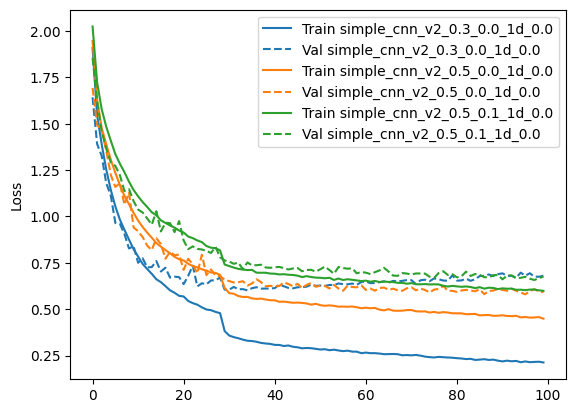

In [192]:
plot_losses(train_loss, val_loss, {k: models[k] for k in ('simple_cnn_v2_0.3_0.0_1d_0.0', 'simple_cnn_v2_0.5_0.0_1d_0.0', 'simple_cnn_v2_0.5_0.1_1d_0.0')})

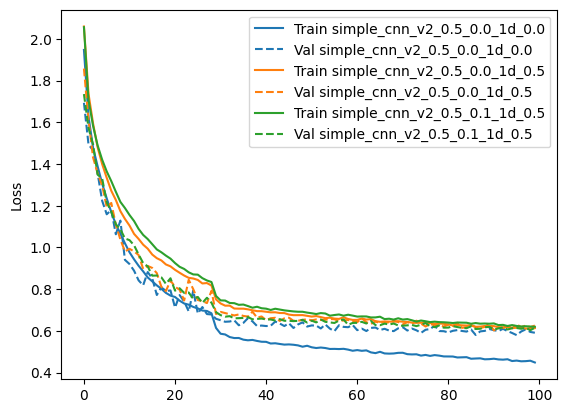

In [195]:
plot_losses(train_loss, val_loss, {k: models[k] for k in ('simple_cnn_v2_0.5_0.0_1d_0.0', 'simple_cnn_v2_0.5_0.0_1d_0.5', 'simple_cnn_v2_0.5_0.1_1d_0.5')})

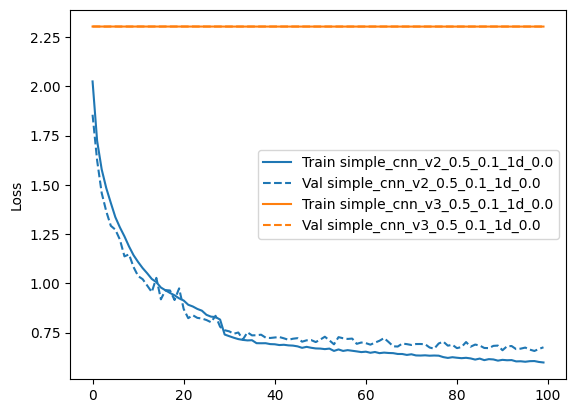

In [198]:
plot_losses(train_loss, val_loss, {k: models[k] for k in ('simple_cnn_v2_0.5_0.1_1d_0.0', 'simple_cnn_v3_0.5_0.1_1d_0.0')})

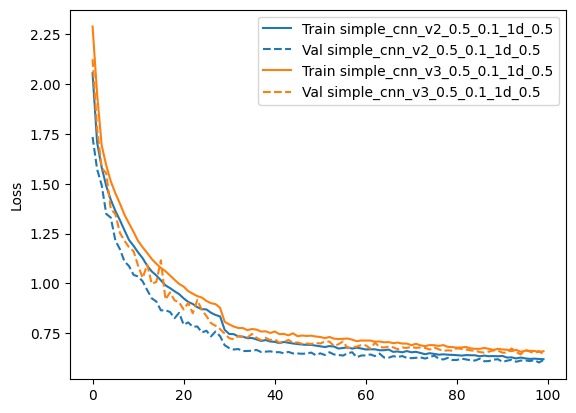

In [199]:
plot_losses(train_loss, val_loss, {k: models[k] for k in ('simple_cnn_v2_0.5_0.1_1d_0.5', 'simple_cnn_v3_0.5_0.1_1d_0.5')})

In [197]:
print_accuracies(models)

** Model: simple_cnn_v2_0.3_0.0_1d_0.0
Accuracy on test set: 80.21%
** Model: simple_cnn_v2_0.5_0.0_1d_0.0
Accuracy on test set: 80.88%
** Model: simple_cnn_v2_0.5_0.0_1d_0.5
Accuracy on test set: 78.24%
** Model: simple_cnn_v2_0.5_0.1_1d_0.0
Accuracy on test set: 76.89%
** Model: simple_cnn_v2_0.5_0.1_1d_0.5
Accuracy on test set: 77.84%
** Model: simple_cnn_v3_0.5_0.1_1d_0.0
Accuracy on test set: 10.00%
** Model: simple_cnn_v3_0.5_0.1_1d_0.5
Accuracy on test set: 77.47%


### Repeat some of the above as v3 wasnt properly implemented for the test above

In [19]:
# note that there was a bug and v3 didnt run properly (the conv wasnt actuylly AFTER, so its identical to v2!)
def initialize_advanced_models_v7():
    models = {}

    models['simple_cnn_v2_0.5_0.0_1d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.0, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v2_0.5_0.0_1d_0.0_CHECK'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.0, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v2_0.5_0.1_1d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v3_0.5_0.1_1d_0.0'] = SimpleCNNv3(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.0)

    return models


In [20]:
models = initialize_advanced_models_v7()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=100, lr=1e-3, reduce_lr = [30])
    print('*'*20)

=== Training simple_cnn_v2_0.5_0.0_1d_0.0
Learning rate: 0.001
Epoch 10, Loss: 1.0984 Validation Loss: 1.1316, Validation Accuracy: 59.72%
Epoch 20, Loss: 0.8691 Validation Loss: 0.8869, Validation Accuracy: 68.88%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.6907 Validation Loss: 0.7892, Validation Accuracy: 72.54%
Epoch 40, Loss: 0.6392 Validation Loss: 0.7470, Validation Accuracy: 74.72%
Epoch 50, Loss: 0.6079 Validation Loss: 0.7321, Validation Accuracy: 74.84%
Epoch 60, Loss: 0.5948 Validation Loss: 0.7401, Validation Accuracy: 75.50%
Epoch 70, Loss: 0.5786 Validation Loss: 0.7299, Validation Accuracy: 75.64%
Epoch 80, Loss: 0.5647 Validation Loss: 0.7114, Validation Accuracy: 76.62%
Epoch 90, Loss: 0.5496 Validation Loss: 0.7067, Validation Accuracy: 76.86%
Epoch 100, Loss: 0.5381 Validation Loss: 0.6792, Validation Accuracy: 77.28%
Training complete in 448.0203s.
********************
=== Training simple_cnn_v2_0.5_0.0_1d_0.0_CHECK
Learning rate: 0.001
Epoch 10, Loss: 1.0703 

In [ ]:
models['simple_cnn_v2_0.5_0.0_1d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.0, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v2_0.5_0.0_1d_0.0_CHECK'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.0, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v2_0.5_0.1_1d_0.0'] = SimpleCNNv2(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v3_0.5_0.1_1d_0.0'] = SimpleCNNv3(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.0)

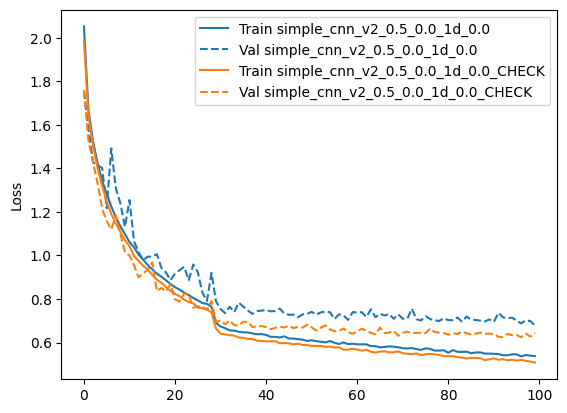

In [22]:
plot_losses(train_loss, val_loss, {k: models[k] for k in ('simple_cnn_v2_0.5_0.0_1d_0.0', 'simple_cnn_v2_0.5_0.0_1d_0.0_CHECK')})

The above plot compares two identical models trained. Such deviations between losses are thus to be considered as "insignificant".

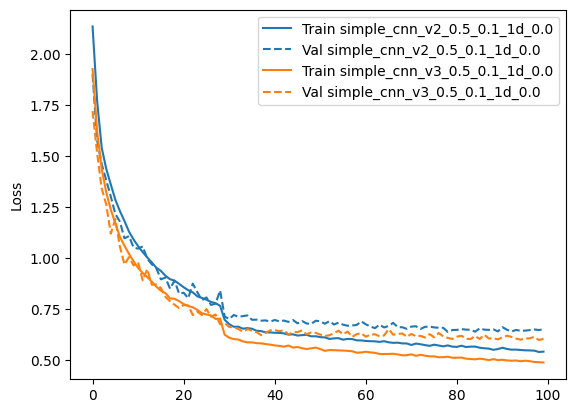

In [24]:
plot_losses(train_loss, val_loss, {k: models[k] for k in ('simple_cnn_v2_0.5_0.1_1d_0.0', 'simple_cnn_v3_0.5_0.1_1d_0.0')})

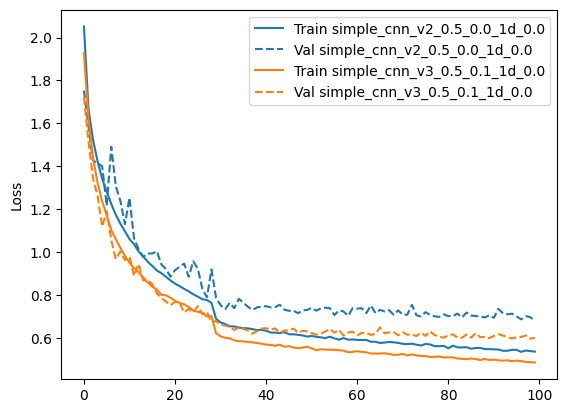

In [25]:
plot_losses(train_loss, val_loss, {k: models[k] for k in ('simple_cnn_v2_0.5_0.0_1d_0.0', 'simple_cnn_v3_0.5_0.1_1d_0.0')})

Best model seems to be indeed applying Dropout AFTER the Average Pool

In [26]:
def initialize_advanced_models_v8():
    models = {}

    models['simple_cnn_v3_0.5_0.1_1d_0.0'] = SimpleCNNv3(dropout_conv_block = 0.5, dropout_final_conv = 0.1, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v3_0.5_0.3_1d_0.0'] = SimpleCNNv3(dropout_conv_block = 0.5, dropout_final_conv = 0.3, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v3_0.5_0.5_1d_0.0'] = SimpleCNNv3(dropout_conv_block = 0.5, dropout_final_conv = 0.5, dropout_2d = False, dropout_fc=0.0)
    models['simple_cnn_v3_0.5_0.5_1d_0.5'] = SimpleCNNv3(dropout_conv_block = 0.5, dropout_final_conv = 0.5, dropout_2d = False, dropout_fc=0.5)

    return models


In [27]:
models = initialize_advanced_models_v8()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=100, lr=1e-3, reduce_lr = [30])
    print('*'*20)

=== Training simple_cnn_v3_0.5_0.1_1d_0.0
Learning rate: 0.001
Epoch 10, Loss: 1.0309 Validation Loss: 0.9894, Validation Accuracy: 65.54%
Epoch 20, Loss: 0.7853 Validation Loss: 0.7317, Validation Accuracy: 74.44%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.6362 Validation Loss: 0.6495, Validation Accuracy: 77.48%
Epoch 40, Loss: 0.5744 Validation Loss: 0.6432, Validation Accuracy: 77.76%
Epoch 50, Loss: 0.5581 Validation Loss: 0.6208, Validation Accuracy: 78.64%
Epoch 60, Loss: 0.5397 Validation Loss: 0.6216, Validation Accuracy: 78.44%
Epoch 70, Loss: 0.5274 Validation Loss: 0.6161, Validation Accuracy: 78.56%
Epoch 80, Loss: 0.5137 Validation Loss: 0.6007, Validation Accuracy: 79.40%
Epoch 90, Loss: 0.5029 Validation Loss: 0.6148, Validation Accuracy: 79.06%
Epoch 100, Loss: 0.4914 Validation Loss: 0.5984, Validation Accuracy: 79.86%
Training complete in 507.8801s.
********************
=== Training simple_cnn_v3_0.5_0.3_1d_0.0
Learning rate: 0.001
Epoch 10, Loss: 1.0741 Valida

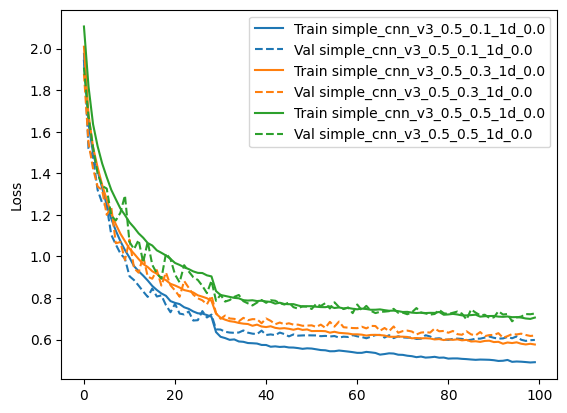

In [28]:
plot_losses(train_loss, val_loss, {k: models[k] for k in ('simple_cnn_v3_0.5_0.1_1d_0.0', 'simple_cnn_v3_0.5_0.3_1d_0.0', 'simple_cnn_v3_0.5_0.5_1d_0.0')})

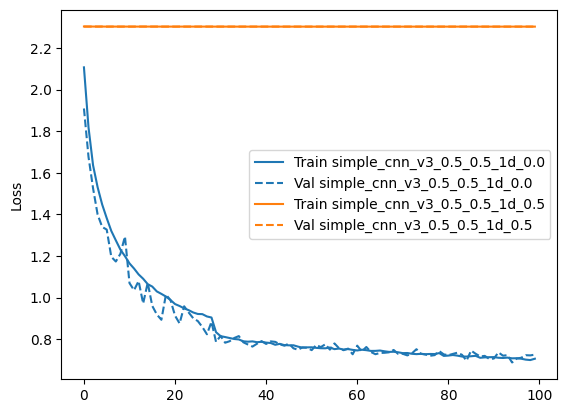

In [29]:
plot_losses(train_loss, val_loss, {k: models[k] for k in ('simple_cnn_v3_0.5_0.5_1d_0.0', 'simple_cnn_v3_0.5_0.5_1d_0.5')})

In [30]:
print_accuracies(models)

** Model: simple_cnn_v3_0.5_0.1_1d_0.0
Accuracy on test set: 79.52%
** Model: simple_cnn_v3_0.5_0.3_1d_0.0
Accuracy on test set: 78.80%
** Model: simple_cnn_v3_0.5_0.5_1d_0.0
Accuracy on test set: 74.53%
** Model: simple_cnn_v3_0.5_0.5_1d_0.5
Accuracy on test set: 10.00%


# BatchNorm and ResNet

Here we will introduce some more advanced architectural concepts, specifically BatchNorm and Residual connections.

For BatchNet I found that without the dropout, the model overfits a lot. Adding a dropout in the final layer doesn't help. Thus, back to dropouts in the conv layers...

In [24]:
class BatchNormBlock(nn.Module):
    def __init__(self, channels, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = channels, out_channels = channels, kernel_size = 3, padding = 'same')
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels =  channels, out_channels =  2 * channels, kernel_size = 3, padding = 'same')
        self.bn2 = nn.BatchNorm2d(2*channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

class BatchNet(nn.Module):
    def __init__(self, dropout_blocks=0.2, dropout_final_conv = 0.5, dropout_fc=0.5):
        super().__init__()

        self.initial_conv =  nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same')
        self.initial_bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.convblock1 = BatchNormBlock(16, dropout_blocks)
        self.convblock2 = BatchNormBlock(32, dropout_blocks)
        self.convblock3 = BatchNormBlock(64, dropout_blocks)

        self.final_conv =  nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding='same')
        self.final_bn =  nn.BatchNorm2d(256)
        self.adaptivepool = nn.AdaptiveAvgPool2d(1) # 256x1x1
        self.final_dropout = nn.Dropout(dropout_final_conv)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.dropout_fc = nn.Dropout(dropout_fc)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # x: 3x32x32
        out = self.initial_conv(x) # 16x32x32
        out = self.initial_bn(out)
        out = self.relu(out)

        out = self.convblock1(out) # 32x16x16
        out = self.convblock2(out) # 64x8x8
        out = self.convblock3(out) # 128x4x4

        out = self.final_conv(out) # 256x4x4
        out = self.final_bn(out)
        out = self.relu(out)
        out = self.adaptivepool(out)  # 256x1x1
        out = self.final_dropout(out)
        
        out = self.flatten(out) # 256
        out = self.fc1(out)  # 256
        out = self.relu(out)
        out = self.dropout_fc(out)
        out = self.fc2(out)  # 10

        return out

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.2):
        """ The skip connection is identity of the input if in_channels == out_channels and stride ==1
            Otherwise, we use a 1x1 conv and/or the stride to match the dimensions.
        """
        super().__init__()

        self.skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels or stride != 1 else nn.Identity()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        skip = self.skip(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + skip
        out = self.relu(out)
        out = self.dropout(out)
        return out

class ResNetv1(nn.Module):
    def __init__(self, dropout_blocks=0.0, dropout_fc=0.0):
        super().__init__()

        self.initial_conv =  nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same') # 3x32x32 -> 16x32x32
        self.initial_bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        self.convblock0 = ResidualBlock(in_channels = 16, out_channels = 32, stride=2, dropout = dropout_blocks) # 16x32x32 -> 32x16x16
        self.convblock1 = ResidualBlock(in_channels = 32, out_channels = 32, stride=1, dropout = dropout_blocks) # 32x16x16-> 32x16x16

        self.convblock2 = ResidualBlock(in_channels = 32, out_channels = 64, stride=2, dropout = dropout_blocks) # 32x16x16 -> 64x8x8
        self.convblock3 = ResidualBlock(in_channels = 64, out_channels = 64, stride=1, dropout = dropout_blocks) # 64x8x8 -> 64x8x8

        self.convblock4 = ResidualBlock(in_channels = 64, out_channels = 128, stride=2, dropout = dropout_blocks) # 64x8x8 -> 128x4x4
        self.convblock5 = ResidualBlock(in_channels = 128, out_channels = 128, stride=1, dropout = dropout_blocks) # 128x4x4 -> 128x4x4

        self.convblock6 = ResidualBlock(in_channels = 128, out_channels = 256, stride=2, dropout = dropout_blocks) # 128x4x4 -> 256x2x2
        self.convblock7 = ResidualBlock(in_channels = 256, out_channels = 256, stride=1, dropout = dropout_blocks) # 256x2x2 -> 256x2x2

        self.adaptivepool = nn.AdaptiveAvgPool2d(1) # 256x2x2  -> 256x1x1

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.dropout_fc = nn.Dropout(dropout_fc)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):

        out = self.initial_conv(x)
        out = self.initial_bn(out)
        out = self.relu(out)

        out = self.convblock0(out)
        out = self.convblock1(out)
        out = self.convblock2(out)
        out = self.convblock3(out)
        out = self.convblock4(out)
        out = self.convblock5(out)
        out = self.convblock6(out)
        out = self.convblock7(out)

        out = self.adaptivepool(out)
        
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout_fc(out)
        out = self.fc2(out)

        return out

class ResNetv2(nn.Module):
    def __init__(self, dropout_blocks=0.0, dropout_fc=0.0):
        super().__init__()

        self.initial_conv =  nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same') # 3x32x32 -> 16x32x32
        self.initial_bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        # 32x32 -> 32x32
        self.convblock0 = ResidualBlock(in_channels = 16, out_channels = 32, stride=1, dropout = dropout_blocks)
        self.convblock1 = ResidualBlock(in_channels = 32, out_channels = 32, stride=1, dropout = dropout_blocks)

        # 32x32 -> 16x16
        self.convblock2 = ResidualBlock(in_channels = 32, out_channels = 64, stride=2, dropout = dropout_blocks)
        self.convblock3 = ResidualBlock(in_channels = 64, out_channels = 64, stride=1, dropout = dropout_blocks)

        # 16x16 -> 8x8
        self.convblock4 = ResidualBlock(in_channels = 64, out_channels = 128, stride=2, dropout = dropout_blocks)
        self.convblock5 = ResidualBlock(in_channels = 128, out_channels = 128, stride=1, dropout = dropout_blocks)

        # 8x8 -> 4x4
        self.convblock6 = ResidualBlock(in_channels = 128, out_channels = 256, stride=2, dropout = dropout_blocks)
        self.convblock7 = ResidualBlock(in_channels = 256, out_channels = 256, stride=1, dropout = dropout_blocks)

        self.adaptivepool = nn.AdaptiveAvgPool2d(1) # 256x4x4  -> 256x1x1

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256, 256)
        self.dropout_fc = nn.Dropout(dropout_fc)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):

        out = self.initial_conv(x)
        out = self.initial_bn(out)
        out = self.relu(out)

        out = self.convblock0(out)
        out = self.convblock1(out)
        out = self.convblock2(out)
        out = self.convblock3(out)
        out = self.convblock4(out)
        out = self.convblock5(out)
        out = self.convblock6(out)
        out = self.convblock7(out)

        out = self.adaptivepool(out)
        
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout_fc(out)
        out = self.fc2(out)

        return out

class ResNetv3(nn.Module):
    def __init__(self, dropout_blocks=0.0):
        super().__init__()

        self.initial_conv =  nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, padding = 'same') # 3x32x32 -> 16x32x32
        self.initial_bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        # 32x32 -> 32x32
        self.convblock0 = ResidualBlock(in_channels = 16, out_channels = 32, stride=1, dropout = dropout_blocks)
        self.convblock1 = ResidualBlock(in_channels = 32, out_channels = 32, stride=1, dropout = dropout_blocks)

        # 32x32 -> 16x16
        self.convblock2 = ResidualBlock(in_channels = 32, out_channels = 64, stride=2, dropout = dropout_blocks)
        self.convblock3 = ResidualBlock(in_channels = 64, out_channels = 64, stride=1, dropout = dropout_blocks)

        # 16x16 -> 8x8
        self.convblock4 = ResidualBlock(in_channels = 64, out_channels = 128, stride=2, dropout = dropout_blocks)
        self.convblock5 = ResidualBlock(in_channels = 128, out_channels = 128, stride=1, dropout = dropout_blocks)

        # 8x8 -> 4x4
        self.convblock6 = ResidualBlock(in_channels = 128, out_channels = 256, stride=2, dropout = dropout_blocks)
        self.convblock7 = ResidualBlock(in_channels = 256, out_channels = 256, stride=1, dropout = dropout_blocks)

        self.adaptivepool = nn.AdaptiveAvgPool2d(1) # 256x4x4  -> 256x1x1

        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):

        out = self.initial_conv(x)
        out = self.initial_bn(out)
        out = self.relu(out)

        out = self.convblock0(out)
        out = self.convblock1(out)
        out = self.convblock2(out)
        out = self.convblock3(out)
        out = self.convblock4(out)
        out = self.convblock5(out)
        out = self.convblock6(out)
        out = self.convblock7(out)

        out = self.adaptivepool(out)
        
        out = self.flatten(out)
        out = self.fc2(out)

        return out


#resnet = ResNetv1(dropout_blocks=0.5, dropout_fc=0.0)
#summary(resnet, input_size=(3, 32, 32), device='cpu')


In [57]:
def initialize_advanced_models_v9():
    models = {}

    models['BatchNet_0.5_0.5_0.0'] = BatchNet(dropout_blocks=0.5, dropout_final_conv = 0.5, dropout_fc=0.0)
    models['ResNetv1_0.5_____0.0'] = ResNetv1(dropout_blocks=0.5, dropout_fc=0.0)
    models['ResNetv2_0.5_____0.0'] = ResNetv2(dropout_blocks=0.5, dropout_fc=0.0)
    models['ResNetv3_0.5_____0.0'] = ResNetv3(dropout_blocks=0.5)

    return models

In [58]:
models = initialize_advanced_models_v9()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=50, lr=1e-3, reduce_lr = [30])
    print('*'*20)

=== Training BatchNet_0.5_0.5_0.0
Learning rate: 0.001
Epoch 10, Loss: 0.7986 Validation Loss: 0.7637, Validation Accuracy: 73.02%
Epoch 20, Loss: 0.6394 Validation Loss: 0.5265, Validation Accuracy: 82.02%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.5237 Validation Loss: 0.4728, Validation Accuracy: 83.64%
Epoch 40, Loss: 0.4878 Validation Loss: 0.4507, Validation Accuracy: 84.46%
Epoch 50, Loss: 0.4734 Validation Loss: 0.4539, Validation Accuracy: 84.32%
Training complete in 251.1793s.
********************
=== Training ResNetv1_0.5_____0.0
Learning rate: 0.001
Epoch 10, Loss: 0.9852 Validation Loss: 0.9270, Validation Accuracy: 67.20%
Epoch 20, Loss: 0.7786 Validation Loss: 0.7119, Validation Accuracy: 75.62%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.6162 Validation Loss: 0.5789, Validation Accuracy: 80.04%
Epoch 40, Loss: 0.5670 Validation Loss: 0.5504, Validation Accuracy: 80.82%
Epoch 50, Loss: 0.5482 Validation Loss: 0.5354, Validation Accuracy: 81.14%
Training comple

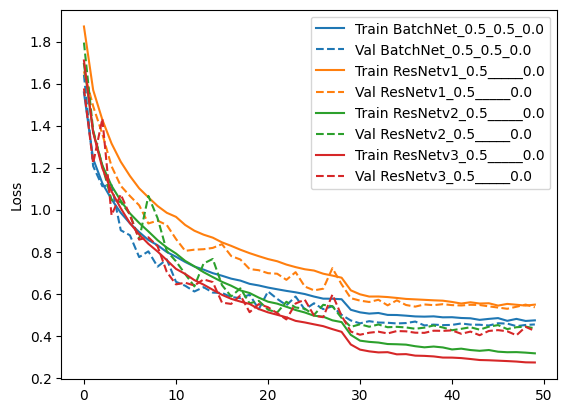

In [59]:
plot_losses(train_loss, val_loss, models)

In [60]:
print_accuracies(models)

** Model: BatchNet_0.5_0.5_0.0
Accuracy on test set: 83.84%
** Model: ResNetv1_0.5_____0.0
Accuracy on test set: 81.20%
** Model: ResNetv2_0.5_____0.0
Accuracy on test set: 85.84%
** Model: ResNetv3_0.5_____0.0
Accuracy on test set: 86.65%


In [61]:
def initialize_advanced_models_v10():
    models = {}

    models['ResNetv3_0.0'] = ResNetv3(dropout_blocks=0.0)
    models['ResNetv3_0.2'] = ResNetv3(dropout_blocks=0.2)
    models['ResNetv3_0.3'] = ResNetv3(dropout_blocks=0.3)
    models['ResNetv3_0.5'] = ResNetv3(dropout_blocks=0.5)
    models['ResNetv3_0.7'] = ResNetv3(dropout_blocks=0.7)

    return models

models = initialize_advanced_models_v10()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=50, lr=1e-3, reduce_lr = [30])
    print('*'*20)

=== Training ResNetv3_0.0
Learning rate: 0.001
Epoch 10, Loss: 0.1258 Validation Loss: 0.7753, Validation Accuracy: 80.26%
Epoch 20, Loss: 0.0417 Validation Loss: 1.2112, Validation Accuracy: 78.38%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.0087 Validation Loss: 0.8696, Validation Accuracy: 83.86%
Epoch 40, Loss: 0.0003 Validation Loss: 0.9667, Validation Accuracy: 84.06%
Epoch 50, Loss: 0.0002 Validation Loss: 1.0729, Validation Accuracy: 83.84%
Training complete in 412.0519s.
********************
=== Training ResNetv3_0.2
Learning rate: 0.001
Epoch 10, Loss: 0.3922 Validation Loss: 0.4901, Validation Accuracy: 83.78%
Epoch 20, Loss: 0.1591 Validation Loss: 0.4945, Validation Accuracy: 86.28%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.0558 Validation Loss: 0.5256, Validation Accuracy: 87.52%
Epoch 40, Loss: 0.0191 Validation Loss: 0.5793, Validation Accuracy: 87.88%
Epoch 50, Loss: 0.0146 Validation Loss: 0.6308, Validation Accuracy: 88.36%
Training complete in 418.0195s.

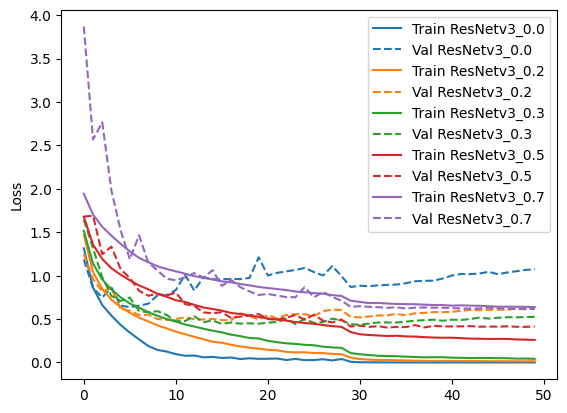

In [62]:
plot_losses(train_loss, val_loss, models)

In [63]:
print_accuracies(models)

** Model: ResNetv3_0.0
Accuracy on test set: 83.15%
** Model: ResNetv3_0.2
Accuracy on test set: 87.79%
** Model: ResNetv3_0.3
Accuracy on test set: 87.58%
** Model: ResNetv3_0.5
Accuracy on test set: 86.80%
** Model: ResNetv3_0.7
Accuracy on test set: 78.16%


In [65]:
def initialize_advanced_models_v11():
    models = {}

    models['ResNetv3_0.2-1'] = ResNetv3(dropout_blocks=0.2)
    models['ResNetv3_0.2-2'] = ResNetv3(dropout_blocks=0.2)
    models['ResNetv3_0.2-3'] = ResNetv3(dropout_blocks=0.2)

    return models

models = initialize_advanced_models_v11()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=50, lr=1e-3, reduce_lr = [30])
    print('*'*20)

=== Training ResNetv3_0.2-1
Learning rate: 0.001
Epoch 10, Loss: 0.3862 Validation Loss: 0.5520, Validation Accuracy: 81.94%
Epoch 20, Loss: 0.1642 Validation Loss: 0.4805, Validation Accuracy: 86.42%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.0570 Validation Loss: 0.5272, Validation Accuracy: 87.70%
Epoch 40, Loss: 0.0206 Validation Loss: 0.6011, Validation Accuracy: 88.24%
Epoch 50, Loss: 0.0146 Validation Loss: 0.6393, Validation Accuracy: 88.44%
Training complete in 421.2383s.
********************
=== Training ResNetv3_0.2-2
Learning rate: 0.001
Epoch 10, Loss: 0.3816 Validation Loss: 0.5104, Validation Accuracy: 83.06%
Epoch 20, Loss: 0.1533 Validation Loss: 0.4908, Validation Accuracy: 86.70%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.0500 Validation Loss: 0.5324, Validation Accuracy: 87.72%
Epoch 40, Loss: 0.0187 Validation Loss: 0.5937, Validation Accuracy: 88.60%
Epoch 50, Loss: 0.0126 Validation Loss: 0.6464, Validation Accuracy: 88.52%
Training complete in 419.67

In [77]:
import numpy as np
val_acc =  np.array([88.44, 88.52, 88.14])
print(f"Mean accuracy: {val_acc.mean():.2f}%")
print(f"Standard deviation: {val_acc.std():.2f}%")

Mean accuracy: 88.37%
Standard deviation: 0.16%


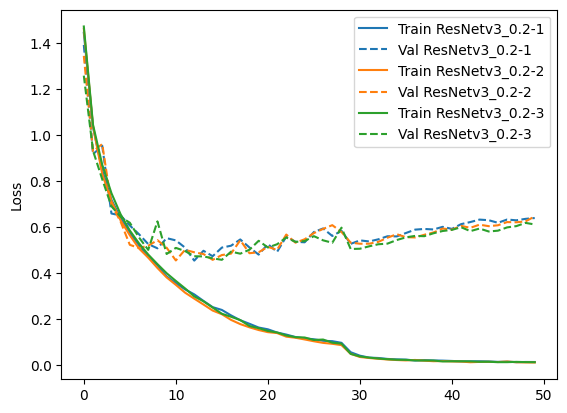

In [66]:
plot_losses(train_loss, val_loss, models)

In [67]:
print_accuracies(models)

** Model: ResNetv3_0.2-1
Accuracy on test set: 88.29%
** Model: ResNetv3_0.2-2
Accuracy on test set: 87.65%
** Model: ResNetv3_0.2-3
Accuracy on test set: 87.43%


In [78]:
import numpy as np
test_acc =  np.array([88.29, 87.65, 87.43])
print(f"Mean accuracy: {test_acc.mean():.2f}%")
print(f"Standard deviation: {test_acc.std():.2f}%")

Mean accuracy: 87.79%
Standard deviation: 0.36%


In [79]:
def initialize_advanced_models_v12():
    models = {}

    models['ResNetv3_0.3-1'] = ResNetv3(dropout_blocks=0.3)
    models['ResNetv3_0.3-2'] = ResNetv3(dropout_blocks=0.3)
    models['ResNetv3_0.3-3'] = ResNetv3(dropout_blocks=0.3)

    return models

models = initialize_advanced_models_v12()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=50, lr=1e-3, reduce_lr = [30])
    print('*'*20)

=== Training ResNetv3_0.3-1
Learning rate: 0.001
Epoch 10, Loss: 0.5021 Validation Loss: 0.5129, Validation Accuracy: 82.50%
Epoch 20, Loss: 0.2766 Validation Loss: 0.4243, Validation Accuracy: 86.20%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.1131 Validation Loss: 0.4236, Validation Accuracy: 88.44%
Epoch 40, Loss: 0.0598 Validation Loss: 0.4821, Validation Accuracy: 88.48%
Epoch 50, Loss: 0.0456 Validation Loss: 0.5269, Validation Accuracy: 88.56%
Training complete in 432.6122s.
********************
=== Training ResNetv3_0.3-2
Learning rate: 0.001
Epoch 10, Loss: 0.5072 Validation Loss: 0.5339, Validation Accuracy: 81.52%
Epoch 20, Loss: 0.2821 Validation Loss: 0.4698, Validation Accuracy: 85.40%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.1174 Validation Loss: 0.4344, Validation Accuracy: 88.08%
Epoch 40, Loss: 0.0625 Validation Loss: 0.5013, Validation Accuracy: 87.92%
Epoch 50, Loss: 0.0465 Validation Loss: 0.5397, Validation Accuracy: 88.16%
Training complete in 425.64

In [80]:
import numpy as np
val_acc =  np.array([ 88.56, 88.16, 88.46])
print(f"Mean accuracy: {val_acc.mean():.2f}%")
print(f"Standard deviation: {val_acc.std():.2f}%")

Mean accuracy: 88.39%
Standard deviation: 0.17%


In [81]:
print_accuracies(models)

** Model: ResNetv3_0.3-1
Accuracy on test set: 87.72%
** Model: ResNetv3_0.3-2
Accuracy on test set: 87.63%
** Model: ResNetv3_0.3-3
Accuracy on test set: 88.52%


In [82]:
import numpy as np
test_acc =  np.array([87.72, 87.63, 88.52])
print(f"Mean accuracy: {test_acc.mean():.2f}%")
print(f"Standard deviation: {test_acc.std():.2f}%")

Mean accuracy: 87.96%
Standard deviation: 0.40%


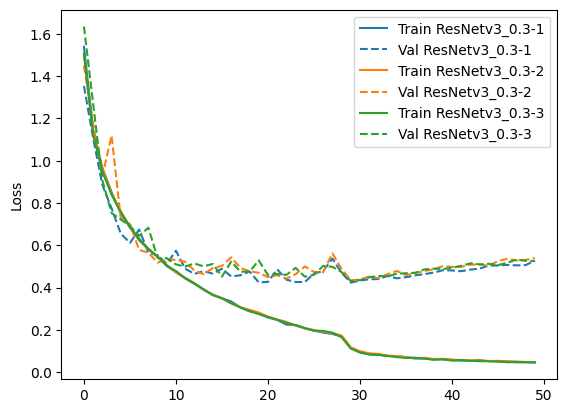

In [83]:
plot_losses(train_loss, val_loss, models)

In [84]:
def initialize_advanced_models_v13():
    models = {}

    models['ResNetv3_0.3'] = ResNetv3(dropout_blocks=0.3)

    return models

models = initialize_advanced_models_v13()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=150, lr=1e-3, reduce_lr = [30,50,100])
    print('*'*20)

=== Training ResNetv3_0.3
Learning rate: 0.001
Epoch 10, Loss: 0.4925 Validation Loss: 0.5610, Validation Accuracy: 81.32%
Epoch 20, Loss: 0.2684 Validation Loss: 0.4803, Validation Accuracy: 84.34%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.1114 Validation Loss: 0.4283, Validation Accuracy: 88.26%
Epoch 40, Loss: 0.0587 Validation Loss: 0.5014, Validation Accuracy: 88.32%
Epoch 50: LR reduced to 1e-05
Epoch 50, Loss: 0.0441 Validation Loss: 0.5257, Validation Accuracy: 88.58%
Epoch 60, Loss: 0.0394 Validation Loss: 0.5244, Validation Accuracy: 88.40%
Epoch 70, Loss: 0.0363 Validation Loss: 0.5262, Validation Accuracy: 88.58%
Epoch 80, Loss: 0.0373 Validation Loss: 0.5254, Validation Accuracy: 88.66%
Epoch 90, Loss: 0.0358 Validation Loss: 0.5319, Validation Accuracy: 88.66%
Epoch 100: LR reduced to 1.0000000000000002e-06
Epoch 100, Loss: 0.0336 Validation Loss: 0.5310, Validation Accuracy: 88.80%
Epoch 110, Loss: 0.0338 Validation Loss: 0.5360, Validation Accuracy: 88.80%
Epoch 

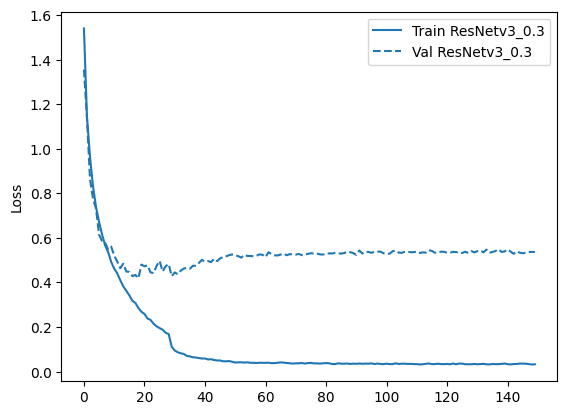

In [85]:
plot_losses(train_loss, val_loss, models)

In [86]:
class ResNetv4(nn.Module):
    def __init__(self, dropout_blocks=0.0):
        super().__init__()

        # 3x32x32 -> 16x32x32
        self.initial_conv =  nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 3, padding = 'same') 
        self.initial_bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        
        # 32x32 -> 32x32
        self.stageI = nn.Sequential(
            ResidualBlock(in_channels = 16, out_channels = 32, stride=1, dropout = dropout_blocks),
            ResidualBlock(in_channels = 32, out_channels = 32, stride=1, dropout = dropout_blocks),
            ResidualBlock(in_channels = 32, out_channels = 32, stride=1, dropout = dropout_blocks),
            ResidualBlock(in_channels = 32, out_channels = 32, stride=1, dropout = dropout_blocks)
        )

        # 32x32 -> 16x16
        self.stageII = nn.Sequential(
            ResidualBlock(in_channels = 32, out_channels = 64, stride=2, dropout = dropout_blocks),
            ResidualBlock(in_channels = 64, out_channels = 64, stride=1, dropout = dropout_blocks),
            ResidualBlock(in_channels = 64, out_channels = 64, stride=1, dropout = dropout_blocks),
            ResidualBlock(in_channels = 64, out_channels = 64, stride=1, dropout = dropout_blocks)
        )

        # 16x16 -> 8x8
        self.stageIII = nn.Sequential(
            ResidualBlock(in_channels = 64, out_channels = 128, stride=2, dropout = dropout_blocks),
            ResidualBlock(in_channels = 128, out_channels = 128, stride=1, dropout = dropout_blocks),
            ResidualBlock(in_channels = 128, out_channels = 128, stride=1, dropout = dropout_blocks),
            ResidualBlock(in_channels = 128, out_channels = 128, stride=1, dropout = dropout_blocks)
        )

        # 8x8 -> 4x4
        self.stageIV = nn.Sequential(
            ResidualBlock(in_channels = 128, out_channels = 256, stride=2, dropout = dropout_blocks),
            ResidualBlock(in_channels = 256, out_channels = 256, stride=1, dropout = dropout_blocks),
            ResidualBlock(in_channels = 256, out_channels = 256, stride=1, dropout = dropout_blocks),
            ResidualBlock(in_channels = 256, out_channels = 256, stride=1, dropout = dropout_blocks)
        )

        self.adaptivepool = nn.AdaptiveAvgPool2d(1) # 256x4x4  -> 256x1x1

        self.flatten = nn.Flatten()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):

        out = self.initial_conv(x)
        out = self.initial_bn(out)
        out = self.relu(out)

        out = self.stageI(out)
        out = self.stageII(out)
        out = self.stageIII(out)
        out = self.stageIV(out)

        out = self.adaptivepool(out)
        
        out = self.flatten(out)
        out = self.fc2(out)

        return out

resnet = ResNetv4(dropout_blocks=0.5)
summary(resnet, input_size=(3, 32, 32), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             544
       BatchNorm2d-5           [-1, 32, 32, 32]              64
            Conv2d-6           [-1, 32, 32, 32]           4,640
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,248
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
          Dropout-12           [-1, 32, 32, 32]               0
    ResidualBlock-13           [-1, 32, 32, 32]               0
         Identity-14           [-1, 32,

In [ ]:
def initialize_advanced_models_v14():
    models = {}

    models['ResNetv4_0.3'] = ResNetv4(dropout_blocks=0.3)

    return models

models = initialize_advanced_models_v14()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=50, lr=1e-3, reduce_lr = [30])
    print('*'*20)

=== Training ResNetv4_0.3
Learning rate: 0.001
Epoch 10, Loss: 0.7188 Validation Loss: 0.6612, Validation Accuracy: 76.94%
Epoch 20, Loss: 0.4801 Validation Loss: 0.5414, Validation Accuracy: 81.60%
Epoch 30: LR reduced to 0.0001
Epoch 30, Loss: 0.2832 Validation Loss: 0.4218, Validation Accuracy: 86.04%
Epoch 40, Loss: 0.2106 Validation Loss: 0.4311, Validation Accuracy: 86.96%
Epoch 50, Loss: 0.1790 Validation Loss: 0.4473, Validation Accuracy: 87.04%
Training complete in 768.6146s.
********************


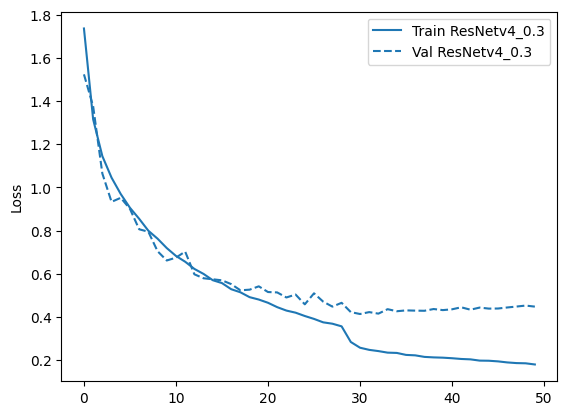

In [88]:
plot_losses(train_loss, val_loss, models)

In [89]:
models = initialize_advanced_models_v14()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=150, lr=1e-3, reduce_lr = [100])
    print('*'*20)

=== Training ResNetv4_0.3
Learning rate: 0.001
Epoch 10, Loss: 0.7200 Validation Loss: 0.7559, Validation Accuracy: 74.06%
Epoch 20, Loss: 0.4755 Validation Loss: 0.5726, Validation Accuracy: 80.50%
Epoch 30, Loss: 0.3437 Validation Loss: 0.4532, Validation Accuracy: 84.84%
Epoch 40, Loss: 0.2510 Validation Loss: 0.4425, Validation Accuracy: 86.32%
Epoch 50, Loss: 0.1874 Validation Loss: 0.4671, Validation Accuracy: 86.56%
Epoch 60, Loss: 0.1472 Validation Loss: 0.4701, Validation Accuracy: 87.32%
Epoch 70, Loss: 0.1215 Validation Loss: 0.5091, Validation Accuracy: 86.80%
Epoch 80, Loss: 0.1076 Validation Loss: 0.4944, Validation Accuracy: 87.10%
Epoch 90, Loss: 0.0913 Validation Loss: 0.5172, Validation Accuracy: 87.06%
Epoch 100: LR reduced to 0.0001
Epoch 100, Loss: 0.0503 Validation Loss: 0.5029, Validation Accuracy: 88.08%
Epoch 110, Loss: 0.0270 Validation Loss: 0.5550, Validation Accuracy: 87.96%
Epoch 120, Loss: 0.0220 Validation Loss: 0.5990, Validation Accuracy: 88.20%
Epoch 

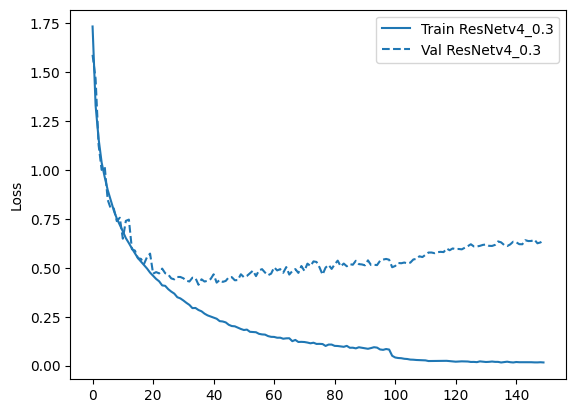

In [90]:
plot_losses(train_loss, val_loss, models)

# Better Data Preprocessing

We seem to stagnate at 88% accuracy even with pretty deep ResNet. Let's see if some data preprocessing / augmentation can help here.

In [129]:
def get_statistics(loader):

    mean = torch.zeros(3)
    std = torch.zeros(3)

    with torch.no_grad():  # No gradients needed for evaluation
        for images, labels in loader:
            B, C, H, W = images.size()

            images = images.view(B, C, -1)  # Reshape to (batch_size, channels, height*width)          
            mean += images.mean(dim=(0, 2))  # Accumulate mean across batch and spatial dimensions
    mean /= len(loader)  # Average over all batches

    with torch.no_grad():  # No gradients needed for evaluation
        for images, labels in loader:
            B, C, H, W = images.size()
            images = images - mean.view(1, C, 1, 1)  # Subtract mean for normalization
            images = images ** 2  # Square the normalized images
            images = images.view(B, C, -1)  # Reshape to (batch_size, channels, height*width)          
            std += images.mean(dim=(0, 2))  # Accumulate mean across batch and spatial dimensions
    std /= len(loader)  # Average over all batches
    std = torch.sqrt(std)

    return mean, std

In [ ]:
t1 = datasets.CIFAR10(root='.', train=True, download=True, transform=transform)
t1_loader = DataLoader(t1, batch_size=100, shuffle=False)


In [130]:
get_statistics(t1_loader)

(tensor([0.4914, 0.4822, 0.4465]), tensor([0.2470, 0.2435, 0.2616]))

Alright, the values match!

In [131]:
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std  = (0.2470, 0.2435, 0.2616)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean, cifar_std),
])


In [132]:
train_dataset = datasets.CIFAR10(root='.', train=True, transform=train_tf)
test_dataset = datasets.CIFAR10(root='.', train=False, transform=test_tf)

val_size = 5000
train_size = len(train_dataset) - val_size
print(f"Splitting training data into {train_size} training and {val_size} validation samples.")
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Splitting training data into 45000 training and 5000 validation samples.


In [133]:
def initialize_advanced_models_v15():
    models = {}

    models['ResNetv4_0.3'] = ResNetv4(dropout_blocks=0.3)

    return models

models = initialize_advanced_models_v15()
train_loss = {}
val_loss = {}
for model_name, model in models.items():
    print(f"=== Training {model_name}")
    train_loss[model_name], val_loss[model_name] = train(model, train_loader, val_loader, num_epochs=200, lr=1e-3, reduce_lr = [100,150])
    print('*'*20)

=== Training ResNetv4_0.3
Learning rate: 0.001
Epoch 10, Loss: 0.8652 Validation Loss: 0.7777, Validation Accuracy: 72.22%
Epoch 20, Loss: 0.6250 Validation Loss: 0.5954, Validation Accuracy: 79.64%
Epoch 30, Loss: 0.5163 Validation Loss: 0.4926, Validation Accuracy: 82.86%
Epoch 40, Loss: 0.4434 Validation Loss: 0.4108, Validation Accuracy: 86.26%
Epoch 50, Loss: 0.3888 Validation Loss: 0.3822, Validation Accuracy: 86.68%
Epoch 60, Loss: 0.3488 Validation Loss: 0.3624, Validation Accuracy: 87.58%
Epoch 70, Loss: 0.3269 Validation Loss: 0.3626, Validation Accuracy: 87.86%
Epoch 80, Loss: 0.2943 Validation Loss: 0.3404, Validation Accuracy: 88.46%
Epoch 90, Loss: 0.2808 Validation Loss: 0.3282, Validation Accuracy: 89.26%
Epoch 100: LR reduced to 0.0001
Epoch 100, Loss: 0.2190 Validation Loss: 0.2822, Validation Accuracy: 90.12%
Epoch 110, Loss: 0.1763 Validation Loss: 0.2726, Validation Accuracy: 90.48%
Epoch 120, Loss: 0.1726 Validation Loss: 0.2755, Validation Accuracy: 90.26%
Epoch 

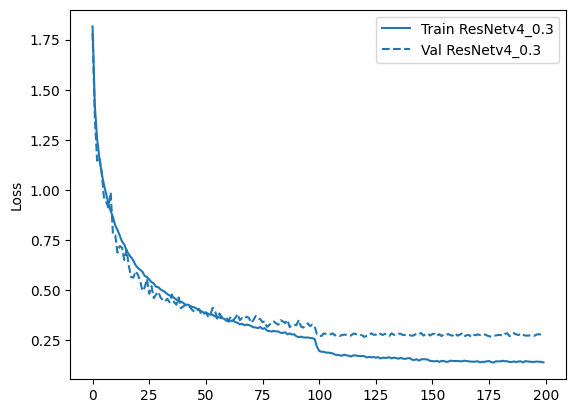

In [135]:
plot_losses(train_loss, val_loss, models)

In [136]:
print_accuracies(models, test_loader = test_loader)

** Model: ResNetv4_0.3
Accuracy on test set: 91.20%


__TODOS__
* need monitoring accuracies as fcn of epoch, not only losses
* better scheduling of the learning reate. cosine annealing?
* migrate to proper codebase

# Suggestions for Improvements

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ViT_B_16_Weights

# Load pretrained Vision Transformer (trained on ImageNet-21K)
weights = ViT_B_16_Weights.IMAGENET21K_1K_V1  # Pretrained on 14M images!
model = models.vit_b_16(weights=weights)

print(f"Model loaded. Total parameters: {sum(p.numel() for p in model.parameters()):,}")
# Output: ~86 million parameters already learned from massive dataset!

# Inspect the model
print(model)
# Last layer: Linear(768, 1000)  ← Outputs 1000 ImageNet classes

In [ ]:
# The pretrained model has:
# - Transformer blocks: Learned general features ✓
# - Classification head: 1000 ImageNet classes ✗

# Replace classification head
num_classes = 10  # CIFAR-10 has 10 classes

# Option 1: Simple replacement
model.heads = nn.Linear(model.heads.head.in_features, num_classes)

# Option 2: Add a small adapter
model.heads = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)

print(model)
# Last layer now: Linear(768, 10) ← Outputs 10 CIFAR classes

In [ ]:
# Freeze transformer backbone
for param in model.encoder.parameters():
    param.requires_grad = False

# Only train new classification head
model.heads.requires_grad_(True)

optimizer = torch.optim.Adam(model.heads.parameters(), lr=1e-3)
# ↑ Normal learning rate (only training small head)

for epoch in range(10):
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Head quickly learns CIFAR-10 decision boundaries

In [ ]:
# Start with frozen backbone, train head
for param in model.encoder.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.heads.parameters(), lr=1e-3)

# Train head for 5 epochs
for epoch in range(5):
    train_epoch()

# Then unfreeze and fine-tune everything
for param in model.encoder.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Very low LR

# Fine-tune for 10 more epochs
for epoch in range(10):
    train_epoch()

full example'

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torchvision.models import ViT_B_16_Weights
from torch.utils.data import DataLoader, random_split
import time

# ============= DATA =============
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(224, padding=28),  # ViT expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                        (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), 
                        (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='.', train=False, download=True, transform=test_transform)

val_size = 5000
train_size = len(train_dataset) - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# ============= LOAD PRETRAINED MODEL =============
print("Loading pretrained ViT (trained on ImageNet-21K)...")
weights = ViT_B_16_Weights.IMAGENET21K_1K_V1
model = models.vit_b_16(weights=weights)

print(f"Pretrained parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============= ADAPT TO CIFAR-10 =============
# Replace classification head
model.heads = nn.Linear(model.heads.head.in_features, num_classes=10)

print(f"Model adapted for 10 classes")

# ============= TRANSFER LEARNING STRATEGY =============
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Phase 1: Train head only (frozen backbone)
print("\n" + "="*60)
print("PHASE 1: Train head only (backbone frozen)")
print("="*60)

for param in model.encoder.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.heads.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0
for epoch in range(5):
    model.train()
    train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validate
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    print(f"Phase 1 Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}, Val Acc: {val_acc*100:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_phase1.pth')

# Phase 2: Fine-tune entire model (low learning rate)
print("\n" + "="*60)
print("PHASE 2: Fine-tune entire model (backbone unfrozen)")
print("="*60)

# Unfreeze all parameters
for param in model.encoder.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Very low!
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

for epoch in range(10):
    model.train()
    train_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validate
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)
    
    val_acc = val_correct / val_total
    print(f"Phase 2 Epoch {epoch+1}, Loss: {train_loss/len(train_loader):.4f}, Val Acc: {val_acc*100:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_phase2.pth')
    
    scheduler.step()

# ============= EVALUATE =============
model.load_state_dict(torch.load('best_model_phase2.pth'))
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total

print(f"\n{'='*60}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"{'='*60}")
# Expected: ~97-99%!

In [ ]:
def train_with_early_stopping(model, train_loader, val_loader, num_epochs, 
                              lr=1e-3, patience=10, reduce_lr=None):
    # ...existing code...
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # ...training code...
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model

In [ ]:
def evaluate_model(model, train_loader, val_loader, test_loader, model_name):
    """Comprehensive model evaluation"""
    metrics = {}
    
    # Accuracies
    train_acc = get_accuracy_detailed(model, train_loader)
    val_acc = get_accuracy_detailed(model, val_loader)
    test_acc = get_accuracy_detailed(model, test_loader)
    
    metrics['train_acc'] = train_acc
    metrics['val_acc'] = val_acc
    metrics['test_acc'] = test_acc
    metrics['overfit_gap'] = train_acc - val_acc
    metrics['generalization_gap'] = val_acc - test_acc
    
    # Model complexity
    metrics['num_params'] = sum(p.numel() for p in model.parameters())
    
    # Stability (run multiple times in production)
    # For now, just note it
    
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"Train Acc:        {train_acc*100:.2f}%")
    print(f"Val Acc:          {val_acc*100:.2f}%  ← PRIMARY METRIC")
    print(f"Test Acc:         {test_acc*100:.2f}%")
    print(f"Overfit Gap:      {metrics['overfit_gap']*100:.2f}%  (ideal: <5%)")
    print(f"Generalization:   {metrics['generalization_gap']*100:.2f}%")
    print(f"Parameters:       {metrics['num_params']:,}")
    print(f"{'='*50}\n")
    
    return metrics

def get_accuracy_detailed(model, loader):
    """Get accuracy and optionally confusion matrix"""
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [ ]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Val Acc': val_accuracies,
    'Test Acc': test_accuracies,
    'Overfit Gap': overfit_gaps,
    'Params': param_counts
})
comparison_df = comparison_df.sort_values('Val Acc', ascending=False)
print(comparison_df)

In [ ]:
def train_with_lr_scheduling(model, train_loader, val_loader, num_epochs, 
                             lr=1e-3, patience=5, factor=0.5):
    """
    Reduce LR when validation accuracy plateaus
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    best_val_acc = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validate
        model.eval()
        val_acc = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                predicted = torch.argmax(outputs, dim=1)
                val_acc += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_acc /= sum(len(batch[1]) for batch in val_loader)
        train_loss /= len(train_loader)
        
        # **LR scheduling based on VALIDATION ACCURACY**
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            print(f"Epoch {epoch+1}: Val Acc improved to {val_acc*100:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                # Reduce learning rate
                old_lr = optimizer.param_groups[0]['lr']
                new_lr = old_lr * factor
                optimizer.param_groups[0]['lr'] = new_lr
                patience_counter = 0
                print(f"Epoch {epoch+1}: Val Acc plateaued. LR: {old_lr:.2e} → {new_lr:.2e}")
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")
    
    return model

# Usage:
# model = SimpleCNNv3(dropout_conv_block=0.5, dropout_final_conv=0.1, dropout_fc=0.0)
# train_with_lr_scheduling(model, train_loader, val_loader, num_epochs=100, 
#                          lr=1e-3, patience=5, factor=0.5)

In [ ]:
# More robust approach
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',          # **Maximize accuracy** (not minimize loss)
    factor=0.5,
    patience=5,
    verbose=True,
    min_lr=1e-7
)

for epoch in range(num_epochs):
    # ... training code ...
    
    # Step scheduler based on VAL ACCURACY
    scheduler.step(val_acc)  # Not val_loss!